In [1]:
import pandas as pd
import numpy as np
import sklearn
import xgboost
import plotly
import sys

# Print versions
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("scikit-learn:", sklearn.__version__)
print("xgboost:", xgboost.__version__)
print("plotly:", plotly.__version__)
print("Python (for random module):", sys.version)

pandas: 2.2.1
numpy: 1.26.4
scikit-learn: 1.6.1
xgboost: 3.0.0
plotly: 5.24.1
Python (for random module): 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]


In [5]:
import pandas as pd
import numpy as np
import sys
import sklearn
import io
import random
import xgboost as xgb
from sklearn.feature_selection import RFE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder

In [7]:
# URLs and data loading (your existing code)
train_url = 'NSL_KDD_Train.csv'
test_url = 'NSL_KDD_Test.csv'

col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]

# Load datasets
df = pd.read_csv(train_url, header=None, names=col_names)
df_test = pd.read_csv(test_url, header=None, names=col_names)

print('Dimensions of the Training set:', df.shape)
print('Dimensions of the Test set:', df_test.shape)

# Define attack types
attack_types = {
    'DoS': ['neptune', 'smurf', 'pod', 'teardrop', 'land', 'back', 'apache2', 'udpstorm', 'processtable', 'mailbomb'],
    'Probe': ['ipsweep', 'nmap', 'portsweep', 'satan', 'mscan', 'saint'],
    'R2L': ['guess_passwd', 'ftp_write', 'imap', 'phf', 'multihop', 'warezmaster', 'warezclient', 'spy', 'xsnoop', 'snmpguess', 'snmpgetattack', 'httptunnel', 'sendmail', 'named'],
    'U2R': ['buffer_overflow', 'loadmodule', 'perl', 'rootkit', 'sqlattack', 'xterm', 'ps']
}

# Create binary labels for each attack type
for dataset in [df, df_test]:
    dataset['DoS'] = dataset['label'].isin(attack_types['DoS']).astype(int)
    dataset['Probe'] = dataset['label'].isin(attack_types['Probe']).astype(int)
    dataset['R2L'] = dataset['label'].isin(attack_types['R2L']).astype(int)
    dataset['U2R'] = dataset['label'].isin(attack_types['U2R']).astype(int)

# Print class distributions
print("\nTraining set attack distributions:")
for attack in ['DoS', 'Probe', 'R2L', 'U2R']:
    print(f"{attack}:", df[attack].value_counts())

print("\nTest set attack distributions:")
for attack in ['DoS', 'Probe', 'R2L', 'U2R']:
    print(f"{attack}:", df_test[attack].value_counts())

Dimensions of the Training set: (125973, 42)
Dimensions of the Test set: (22544, 42)

Training set attack distributions:
DoS: DoS
0    80046
1    45927
Name: count, dtype: int64
Probe: Probe
0    114317
1     11656
Name: count, dtype: int64
R2L: R2L
0    124978
1       995
Name: count, dtype: int64
U2R: U2R
0    125921
1        52
Name: count, dtype: int64

Test set attack distributions:
DoS: DoS
0    15086
1     7458
Name: count, dtype: int64
Probe: Probe
0    20123
1     2421
Name: count, dtype: int64
R2L: R2L
0    19668
1     2876
Name: count, dtype: int64
U2R: U2R
0    22477
1       67
Name: count, dtype: int64


In [9]:
df.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,DoS,Probe,R2L,U2R
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.00,0.00,0.00,0.05,0.00,normal,0,0,0,0
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,normal,0,0,0,0
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.00,1.00,1.00,0.00,0.00,neptune,1,0,0,0
3,0,tcp,http,SF,232,8153,0,0,0,0,...,0.04,0.03,0.01,0.00,0.01,normal,0,0,0,0
4,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,normal,0,0,0,0


In [11]:
print('Label distribution Training set:')
print(df['label'].value_counts())
print()
print('Label distribution Test set:')
print(df_test['label'].value_counts())

Label distribution Training set:
label
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: count, dtype: int64

Label distribution Test set:
label
normal             9711
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess           331
saint               319
mailbomb            293
snmpgetattac

In [13]:
print('Training set:')
for col_name in df.columns:
    if df[col_name].dtypes == 'object' :
        unique_cat = len(df[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

print()
print('Distribution of categories in service:')
print(df['service'].value_counts().sort_values(ascending=False).head())

Training set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 70 categories
Feature 'flag' has 11 categories
Feature 'label' has 23 categories

Distribution of categories in service:
service
http        40338
private     21853
domain_u     9043
smtp         7313
ftp_data     6860
Name: count, dtype: int64


In [15]:
# Test set
print('Test set:')
for col_name in df_test.columns:
    if df_test[col_name].dtypes == 'object' :
        unique_cat = len(df_test[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))


Test set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 64 categories
Feature 'flag' has 11 categories
Feature 'label' has 38 categories


In [17]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import pickle

# Define categorical columns
categorical_columns = ['protocol_type', 'service', 'flag']

# Create copies ...
df_categorical_values = df[categorical_columns].copy()
testdf_categorical_values = df_test[categorical_columns].copy()

# Initialize LabelEncoder dictionary
label_encoders = {}

# Fit and transform each categorical column
for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    # Combine training and test values to handle all possible categories
    all_values = pd.concat([df_categorical_values[column], testdf_categorical_values[column]]).unique()
    label_encoders[column].fit(all_values)

    # Transform the data using loc ...
    df_categorical_values.loc[:, column] = label_encoders[column].transform(df_categorical_values[column])
    testdf_categorical_values.loc[:, column] = label_encoders[column].transform(testdf_categorical_values[column])

# Save the label encoders for deployment
with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

print("Original categorical data:")
print(df[categorical_columns].head())
print("\nEncoded categorical data:")
print(df_categorical_values.head())

# Store category mappings for verification
mappings = {}
for column in categorical_columns:
    mappings[column] = dict(zip(label_encoders[column].classes_, 
                               label_encoders[column].transform(label_encoders[column].classes_)))

print("\nCategory mappings:")
for column, mapping in mappings.items():
    print(f"\n{column}:", mapping)

Original categorical data:
  protocol_type   service flag
0           tcp  ftp_data   SF
1           udp     other   SF
2           tcp   private   S0
3           tcp      http   SF
4           tcp      http   SF

Encoded categorical data:
  protocol_type service flag
0             1      20    9
1             2      44    9
2             1      49    5
3             1      24    9
4             1      24    9

Category mappings:

protocol_type: {'icmp': 0, 'tcp': 1, 'udp': 2}

service: {'IRC': 0, 'X11': 1, 'Z39_50': 2, 'aol': 3, 'auth': 4, 'bgp': 5, 'courier': 6, 'csnet_ns': 7, 'ctf': 8, 'daytime': 9, 'discard': 10, 'domain': 11, 'domain_u': 12, 'echo': 13, 'eco_i': 14, 'ecr_i': 15, 'efs': 16, 'exec': 17, 'finger': 18, 'ftp': 19, 'ftp_data': 20, 'gopher': 21, 'harvest': 22, 'hostnames': 23, 'http': 24, 'http_2784': 25, 'http_443': 26, 'http_8001': 27, 'imap4': 28, 'iso_tsap': 29, 'klogin': 30, 'kshell': 31, 'ldap': 32, 'link': 33, 'login': 34, 'mtp': 35, 'name': 36, 'netbios_dgm': 37,

In [19]:
# Create feature names for one-hot encoding
# Protocol type features
unique_protocol = sorted(pd.concat([df['protocol_type'], df_test['protocol_type']]).unique())
protocol_features = [f'protocol_type_{x}' for x in unique_protocol]

# Service features
unique_service = sorted(pd.concat([df['service'], df_test['service']]).unique())
service_features = [f'service_{x}' for x in unique_service]

# Flag features
unique_flag = sorted(pd.concat([df['flag'], df_test['flag']]).unique())
flag_features = [f'flag_{x}' for x in unique_flag]

# Combine all feature names
feature_names = protocol_features + service_features + flag_features

# These will be used in the next cell for one-hot encoding
encoded_feature_names = feature_names

In [21]:
# We already have encoded values from our previous step
# Let's verify the encoding is consistent

print("Original categorical values:")
print(df_categorical_values.head())
print('--------------------')

# Our encoded values are already in df_categorical_values from the previous step
# No need to re-encode, just verify
print("Encoded categorical values:")
print(df_categorical_values.head())
print('--------------------')

# Verify test set encoding
print("Test set encoded values:")
print(testdf_categorical_values.head())

# Verify the mappings are consistent
print("\nVerifying encoding mappings:")
for column in categorical_columns:
    print(f"\n{column} unique values:")
    print("Training:", sorted(df_categorical_values[column].unique()))
    print("Test:", sorted(testdf_categorical_values[column].unique()))

Original categorical values:
  protocol_type service flag
0             1      20    9
1             2      44    9
2             1      49    5
3             1      24    9
4             1      24    9
--------------------
Encoded categorical values:
  protocol_type service flag
0             1      20    9
1             2      44    9
2             1      49    5
3             1      24    9
4             1      24    9
--------------------
Test set encoded values:
  protocol_type service flag
0             1      49    1
1             1      49    1
2             1      20    9
3             0      14    9
4             1      60    2

Verifying encoding mappings:

protocol_type unique values:
Training: [0, 1, 2]
Test: [0, 1, 2]

service unique values:
Training: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 5

In [23]:
# Initialize OneHotEncoder with settings for deployment
enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit the encoder on both training and test data to capture all categories
enc.fit(pd.concat([df_categorical_values, testdf_categorical_values]))

# Transform training data
df_categorical_values_encoded = enc.transform(df_categorical_values)
df_cat_data = pd.DataFrame(df_categorical_values_encoded, columns=feature_names)

# Transform test data
testdf_categorical_values_encoded = enc.transform(testdf_categorical_values)
testdf_cat_data = pd.DataFrame(testdf_categorical_values_encoded, columns=feature_names)

# Save the encoder for deployment
with open('onehot_encoder.pkl', 'wb') as f:
    pickle.dump({
        'encoder': enc,
        'feature_names': feature_names
    }, f)

print("Training data shape:", df_cat_data.shape)
print("Test data shape:", testdf_cat_data.shape)
print("\nFirst 5 rows of encoded training data:")
print(df_cat_data.head())

# Verify all features are present
print("\nFeature counts:")
print(f"Protocol features: {len([c for c in df_cat_data.columns if c.startswith('protocol_type_')])}")
print(f"Service features: {len([c for c in df_cat_data.columns if c.startswith('service_')])}")
print(f"Flag features: {len([c for c in df_cat_data.columns if c.startswith('flag_')])}")

Training data shape: (125973, 84)
Test data shape: (22544, 84)

First 5 rows of encoded training data:
   protocol_type_icmp  protocol_type_tcp  protocol_type_udp  service_IRC  \
0                 0.0                1.0                0.0          0.0   
1                 0.0                0.0                1.0          0.0   
2                 0.0                1.0                0.0          0.0   
3                 0.0                1.0                0.0          0.0   
4                 0.0                1.0                0.0          0.0   

   service_X11  service_Z39_50  service_aol  service_auth  service_bgp  \
0          0.0             0.0          0.0           0.0          0.0   
1          0.0             0.0          0.0           0.0          0.0   
2          0.0             0.0          0.0           0.0          0.0   
3          0.0             0.0          0.0           0.0          0.0   
4          0.0             0.0          0.0           0.0          0.0

In [25]:
# No need to manually handle differences since our OneHotEncoder already handles this
# But let's verify the shapes are correct
print("Before joining:")
print("Training data shape:", df.shape)
print("Training categorical data shape:", df_cat_data.shape)
print("Test data shape:", df_test.shape)
print("Test categorical data shape:", testdf_cat_data.shape)

# Join encoded categorical data with original dataframes
newdf = df.copy()
newdf_test = df_test.copy()

# Add encoded categorical columns
for col in df_cat_data.columns:
    newdf[col] = df_cat_data[col]
    newdf_test[col] = testdf_cat_data[col]

# Drop original categorical columns
categorical_columns = ['protocol_type', 'service', 'flag']
newdf.drop(categorical_columns, axis=1, inplace=True)
newdf_test.drop(categorical_columns, axis=1, inplace=True)

print("\nAfter joining:")
print("Final training data shape:", newdf.shape)
print("Final test data shape:", newdf_test.shape)

# Verify all encoded features are present in both datasets
print("\nVerifying feature consistency:")
train_cols = set(newdf.columns)
test_cols = set(newdf_test.columns)
print("Features only in training:", train_cols - test_cols)
print("Features only in testing:", test_cols - train_cols)

# Save the final column order for deployment
column_order = list(newdf.columns)
with open('column_order.pkl', 'wb') as f:
    pickle.dump(column_order, f)

Before joining:
Training data shape: (125973, 46)
Training categorical data shape: (125973, 84)
Test data shape: (22544, 46)
Test categorical data shape: (22544, 84)

After joining:
Final training data shape: (125973, 127)
Final test data shape: (22544, 127)

Verifying feature consistency:
Features only in training: set()
Features only in testing: set()


In [ ]:
# contain the final preprocessed features and the multiclass label (0-4)

# Import necessary libraries
from imblearn.over_sampling import SMOTE
import pandas as pd # Needed for value_counts verification

# 1. Separate features (X) and target (y) for TRAINING data
# We use the multiclass label column ('label') created in Cell 13
# We drop the binary columns ('DoS', 'Probe', etc.) as they are alternative labels
# or potentially redundant if the goal is multiclass classification.
#X_train = newdf.drop(['label', 'DoS', 'Probe', 'R2L', 'U2R'], axis=1)
#y_train = newdf['label']

# Also prepare the TEST data (features ONLY)
#X_test = newdf_test.drop(['label', 'DoS', 'Probe', 'R2L', 'U2R'], axis=1)
#y_test = newdf_test['label'] # Keep original test labels for evaluation

#print("Original training set feature shape:", X_train.shape)
#print("Original training label distribution:")
#print(y_train.value_counts().sort_index())

# 2. Instantiate SMOTE
# 'sampling_strategy='auto'' means resample all classes BUT the majority class
# 'k_neighbors' is the number of nearest neighbors to use for synthesis (default is 5)
# 'random_state' ensures reproducibility
#smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)
#print("\nInstantiated SMOTE.")

# 3. Apply SMOTE to the TRAINING data ONLY
#print("Applying SMOTE (this might take some time)...")
#X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
#print("Finished applying SMOTE.")

# 4. Verify the new distribution
#print("\nResampled training set feature shape:", X_train_smote.shape)
#print("Resampled training label distribution:")
# Convert y_train_smote back to a Pandas Series for value_counts
#print(pd.Series(y_train_smote).value_counts().sort_index())

# 5. Now, you would train your model using the resampled data:
# model.fit(X_train_smote, y_train_smote)

# 6. Evaluate it on the ORIGINAL, UNTOUCHED test set:
# predictions = model.predict(X_test)
# report = classification_report(y_test, predictions)
# print(report)

In [27]:
# Define attack type mappings
attack_types = {
    # 0: Normal traffic
    'normal': 0,
    
    # 1: DoS (Denial of Service)
    'neptune': 1, 'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 
    'teardrop': 1, 'mailbomb': 1, 'apache2': 1, 'processtable': 1, 
    'udpstorm': 1, 'worm': 1,
    
    # 2: Probe
    'ipsweep': 2, 'nmap': 2, 'portsweep': 2, 'satan': 2, 
    'mscan': 2, 'saint': 2,
    
    # 3: R2L (Remote to Local)
    'ftp_write': 3, 'guess_passwd': 3, 'imap': 3, 'multihop': 3, 
    'phf': 3, 'spy': 3, 'warezclient': 3, 'warezmaster': 3, 
    'sendmail': 3, 'named': 3, 'snmpgetattack': 3, 'snmpguess': 3, 
    'xlock': 3, 'xsnoop': 3, 'httptunnel': 3,
    
    # 4: U2R (User to Root)
    'buffer_overflow': 4, 'loadmodule': 4, 'perl': 4, 'rootkit': 4, 
    'ps': 4, 'sqlattack': 4, 'xterm': 4
}

# Save attack mappings for deployment
with open('attack_mappings.pkl', 'wb') as f:
    pickle.dump({
        'attack_types': attack_types,
        'attack_categories': {
            0: 'Normal',
            1: 'DoS',
            2: 'Probe',
            3: 'R2L',
            4: 'U2R'
        }
    }, f)

# Extract and transform labels
labeldf = newdf['label']
labeldf_test = newdf_test['label']

# Apply the mapping
newlabeldf = labeldf.replace(attack_types)
newlabeldf_test = labeldf_test.replace(attack_types)

# Update the dataframes with new labels
newdf['label'] = newlabeldf
newdf_test['label'] = newlabeldf_test

# Verify the transformation
print("Label distribution in training set:")
print(newdf['label'].value_counts().sort_index())
print("\nLabel distribution in test set:")
print(newdf_test['label'].value_counts().sort_index())

# Calculate class weights for imbalanced learning
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight('balanced', 
                                   classes=np.unique(newdf['label']), 
                                   y=newdf['label'])
weight_dict = dict(zip(np.unique(newdf['label']), class_weights))

print("\nClass weights for imbalanced learning:")
for class_label, weight in weight_dict.items():
    print(f"Class {class_label}: {weight:.2f}")

Label distribution in training set:
label
0    67343
1    45927
2    11656
3      995
4       52
Name: count, dtype: int64

Label distribution in test set:
label
0    9711
1    7460
2    2421
3    2885
4      67
Name: count, dtype: int64

Class weights for imbalanced learning:
Class 0: 0.37
Class 1: 0.55
Class 2: 2.16
Class 3: 25.32
Class 4: 484.51


C:\Users\Anays\AppData\Local\Temp\ipykernel_17804\4072834380.py:44: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  newlabeldf = labeldf.replace(attack_types)
C:\Users\Anays\AppData\Local\Temp\ipykernel_17804\4072834380.py:45: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  newlabeldf_test = labeldf_test.replace(attack_types)


In [29]:
# Create binary classification datasets with proper documentation
attack_datasets = {
    'DoS': {
        'labels': [0, 1],  # Normal vs DoS
        'description': 'Denial of Service attacks',
        'train': None,
        'test': None
    },
    'Probe': {
        'labels': [0, 2],  # Normal vs Probe
        'description': 'Probing/Scanning attacks',
        'train': None,
        'test': None
    },
    'R2L': {
        'labels': [0, 3],  # Normal vs R2L
        'description': 'Remote to Local attacks',
        'train': None,
        'test': None
    },
    'U2R': {
        'labels': [0, 4],  # Normal vs U2R
        'description': 'User to Root attacks',
        'train': None,
        'test': None
    }
}

# Create binary datasets and calculate class weights
from sklearn.utils.class_weight import compute_class_weight

for attack_type, dataset_info in attack_datasets.items():
    # Create training dataset
    train_data = newdf[newdf['label'].isin(dataset_info['labels'])].copy()
    test_data = newdf_test[newdf_test['label'].isin(dataset_info['labels'])].copy()
    
    # Store datasets
    attack_datasets[attack_type]['train'] = train_data
    attack_datasets[attack_type]['test'] = test_data
    
    # Calculate class weights
    class_weights = compute_class_weight('balanced',
                                       classes=np.unique(train_data['label']),
                                       y=train_data['label'])
    attack_datasets[attack_type]['class_weights'] = dict(zip(dataset_info['labels'], class_weights))

# Print dataset information
print("Binary Classification Datasets Summary:")
print("=====================================")
for attack_type, dataset_info in attack_datasets.items():
    print(f"\n{attack_type} Attack Detection:")
    print(f"Description: {dataset_info['description']}")
    print("Training Data:")
    print(dataset_info['train']['label'].value_counts().sort_index())
    print("\nTest Data:")
    print(dataset_info['test']['label'].value_counts().sort_index())
    print("\nClass Weights:")
    print(dataset_info['class_weights'])
    print("-" * 50)

# Save the dataset configurations for deployment
with open('attack_datasets_config.pkl', 'wb') as f:
    pickle.dump({
        'attack_types': list(attack_datasets.keys()),
        'label_pairs': {k: v['labels'] for k, v in attack_datasets.items()},
        'descriptions': {k: v['description'] for k, v in attack_datasets.items()}
    }, f)

Binary Classification Datasets Summary:

DoS Attack Detection:
Description: Denial of Service attacks
Training Data:
label
0    67343
1    45927
Name: count, dtype: int64

Test Data:
label
0    9711
1    7460
Name: count, dtype: int64

Class Weights:
{0: 0.8409931247494171, 1: 1.2331526117534348}
--------------------------------------------------

Probe Attack Detection:
Description: Probing/Scanning attacks
Training Data:
label
0    67343
2    11656
Name: count, dtype: int64

Test Data:
label
0    9711
2    2421
Name: count, dtype: int64

Class Weights:
{0: 0.5865420310945458, 2: 3.3887697323266988}
--------------------------------------------------

R2L Attack Detection:
Description: Remote to Local attacks
Training Data:
label
0    67343
3      995
Name: count, dtype: int64

Test Data:
label
0    9711
3    2885
Name: count, dtype: int64

Class Weights:
{0: 0.507387553272055, 3: 34.34070351758794}
--------------------------------------------------

U2R Attack Detection:
Description: 

In [31]:
to_drop_DoS = [0,1]
to_drop_Probe = [0,2]
to_drop_R2L = [0,3]
to_drop_U2R = [0,4]

# Training sets
DoS_df = newdf[newdf['label'].isin([0, 1])]
Probe_df = newdf[newdf['label'].isin([0, 2])]
R2L_df = newdf[newdf['label'].isin([0, 3])]
U2R_df = newdf[newdf['label'].isin([0, 4])]

# Test sets
DoS_df_test = newdf_test[newdf_test['label'].isin([0, 1])]
Probe_df_test = newdf_test[newdf_test['label'].isin([0, 2])]
R2L_df_test = newdf_test[newdf_test['label'].isin([0, 3])]
U2R_df_test = newdf_test[newdf_test['label'].isin([0, 4])]

# Remap labels to 0 (Normal) and 1 (Attack) for binary classifiers
Probe_df['label'] = Probe_df['label'].replace({2: 1})
Probe_df_test['label'] = Probe_df_test['label'].replace({2: 1})

R2L_df['label'] = R2L_df['label'].replace({3: 1})
R2L_df_test['label'] = R2L_df_test['label'].replace({3: 1})

U2R_df['label'] = U2R_df['label'].replace({4: 1})
U2R_df_test['label'] = U2R_df_test['label'].replace({4: 1})


print('Train:')
print('Dimensions of DoS:', DoS_df.shape)
print('Dimensions of Probe:', Probe_df.shape)
print('Dimensions of R2L:', R2L_df.shape)
print('Dimensions of U2R:', U2R_df.shape)
print()
print('Test:')
print('Dimensions of DoS:', DoS_df_test.shape)
print('Dimensions of Probe:', Probe_df_test.shape)
print('Dimensions of R2L:', R2L_df_test.shape)
print('Dimensions of U2R:', U2R_df_test.shape)


Train:
Dimensions of DoS: (113270, 127)
Dimensions of Probe: (78999, 127)
Dimensions of R2L: (68338, 127)
Dimensions of U2R: (67395, 127)

Test:
Dimensions of DoS: (17171, 127)
Dimensions of Probe: (12132, 127)
Dimensions of R2L: (12596, 127)
Dimensions of U2R: (9778, 127)


C:\Users\Anays\AppData\Local\Temp\ipykernel_17804\3420754432.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Probe_df['label'] = Probe_df['label'].replace({2: 1})
C:\Users\Anays\AppData\Local\Temp\ipykernel_17804\3420754432.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Probe_df_test['label'] = Probe_df_test['label'].replace({2: 1})
C:\Users\Anays\AppData\Local\Temp\ipykernel_17804\3420754432.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [33]:
# Split dataframes into X & Y
X_DoS = DoS_df.drop(columns=['label'])
Y_DoS = DoS_df['label']

X_Probe = Probe_df.drop(columns=['label'])
Y_Probe = Probe_df['label']

X_R2L = R2L_df.drop(columns=['label'])
Y_R2L = R2L_df['label']

X_U2R = U2R_df.drop(columns=['label'])
Y_U2R = U2R_df['label']

# Test set
X_DoS_test = DoS_df_test.drop(columns=['label'])
Y_DoS_test = DoS_df_test['label']

X_Probe_test = Probe_df_test.drop(columns=['label'])
Y_Probe_test = Probe_df_test['label']

X_R2L_test = R2L_df_test.drop(columns=['label'])
Y_R2L_test = R2L_df_test['label']

X_U2R_test = U2R_df_test.drop(columns=['label'])
Y_U2R_test = U2R_df_test['label']

In [35]:
from sklearn.preprocessing import StandardScaler
import pickle

# Dictionary to store scalers
scalers = {
    'DoS': StandardScaler(),
    'Probe': StandardScaler(),
    'R2L': StandardScaler(),
    'U2R': StandardScaler()
}

# Scale features for each attack type
X_DoS_scaled = scalers['DoS'].fit_transform(X_DoS)
X_DoS_test_scaled = scalers['DoS'].transform(X_DoS_test)

X_Probe_scaled = scalers['Probe'].fit_transform(X_Probe)
X_Probe_test_scaled = scalers['Probe'].transform(X_Probe_test)

X_R2L_scaled = scalers['R2L'].fit_transform(X_R2L)
X_R2L_test_scaled = scalers['R2L'].transform(X_R2L_test)

X_U2R_scaled = scalers['U2R'].fit_transform(X_U2R)
X_U2R_test_scaled = scalers['U2R'].transform(X_U2R_test)

# Save the scalers for deployment
for attack_type, scaler in scalers.items():
    with open(f'scaler_{attack_type}.pkl', 'wb') as f:
        pickle.dump(scaler, f)

# Print shapes to verify
print("Scaled dataset shapes:")
print(f"DoS - Train: {X_DoS_scaled.shape}, Test: {X_DoS_test_scaled.shape}")
print(f"Probe - Train: {X_Probe_scaled.shape}, Test: {X_Probe_test_scaled.shape}")
print(f"R2L - Train: {X_R2L_scaled.shape}, Test: {X_R2L_test_scaled.shape}")
print(f"U2R - Train: {X_U2R_scaled.shape}, Test: {X_U2R_test_scaled.shape}")

# Save feature names for reference
feature_names = list(X_DoS.columns)
with open('feature_names.pkl', 'wb') as f:
    pickle.dump(feature_names, f)

Scaled dataset shapes:
DoS - Train: (113270, 126), Test: (17171, 126)
Probe - Train: (78999, 126), Test: (12132, 126)
R2L - Train: (68338, 126), Test: (12596, 126)
U2R - Train: (67395, 126), Test: (9778, 126)


In [37]:
# Get feature names and verify they're consistent across datasets
colNames = list(X_DoS.columns)

# Verify feature consistency
feature_checks = {
    'DoS': (X_DoS.columns, X_DoS_test.columns),
    'Probe': (X_Probe.columns, X_Probe_test.columns),
    'R2L': (X_R2L.columns, X_R2L_test.columns),
    'U2R': (X_U2R.columns, X_U2R_test.columns)
}

# Check feature consistency across all datasets
all_match = True
for attack_type, (train_cols, test_cols) in feature_checks.items():
    if not all(train_cols == colNames):
        print(f"Warning: {attack_type} training features don't match DoS features!")
        all_match = False
    if not all(test_cols == colNames):
        print(f"Warning: {attack_type} test features don't match DoS features!")
        all_match = False

if all_match:
    print("✓ All features are consistent across datasets")
    print(f"Number of features: {len(colNames)}")
    
    # Save feature names for deployment
    with open('feature_names.pkl', 'wb') as f:
        pickle.dump({
            'feature_names': colNames,
            'n_features': len(colNames)
        }, f)
    
    print("\nFeature categories:")
    print("Numeric features:", len([col for col in colNames if not (col.startswith('protocol_type_') or col.startswith('service_') or col.startswith('flag_'))]))
    print("Protocol features:", len([col for col in colNames if col.startswith('protocol_type_')]))
    print("Service features:", len([col for col in colNames if col.startswith('service_')]))
    print("Flag features:", len([col for col in colNames if col.startswith('flag_')]))
else:
    print("! Warning: Feature inconsistency detected")

✓ All features are consistent across datasets
Number of features: 126

Feature categories:
Numeric features: 42
Protocol features: 3
Service features: 70
Flag features: 11


In [39]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np

# Model configurations for each attack type
model_configs = {
    'DoS': {
        'params': {
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'max_depth': 6,
            'learning_rate': 0.1,
            'n_estimators': 100,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'scale_pos_weight': len(Y_DoS[Y_DoS==0]) / len(Y_DoS[Y_DoS==1])
        },
        'X_train': X_DoS_scaled,
        'y_train': Y_DoS,
        'X_test': X_DoS_test_scaled,
        'y_test': Y_DoS_test
    },
    'Probe': {
        'params': {
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'max_depth': 6,
            'learning_rate': 0.1,
            'n_estimators': 100,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'scale_pos_weight': len(Y_Probe[Y_Probe==0]) / len(Y_Probe[Y_Probe==1])
        },
        'X_train': X_Probe_scaled,
        'y_train': Y_Probe,
        'X_test': X_Probe_test_scaled,
        'y_test': Y_Probe_test
    },
        'R2L': {
        'params': {
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'max_depth': 6,
            'learning_rate': 0.1,
            'n_estimators': 100,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'scale_pos_weight': len(Y_R2L[Y_R2L==0]) / len(Y_R2L[Y_R2L==1])
        },
        'X_train': X_R2L_scaled,
        'y_train': Y_R2L,
        'X_test': X_R2L_test_scaled,
        'y_test': Y_R2L_test
    },
    'U2R': {
        'params': {
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'max_depth': 6,
            'learning_rate': 0.1,
            'n_estimators': 100,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'scale_pos_weight': len(Y_U2R[Y_U2R==0]) / len(Y_U2R[Y_U2R==1])
        },
        'X_train': X_U2R_scaled,
        'y_train': Y_U2R,
        'X_test': X_U2R_test_scaled,
        'y_test': Y_U2R_test
    }
}

models = {}
for attack_type, config in model_configs.items():
    print(f"\nTraining {attack_type} Detection Model:")

    model = xgb.XGBClassifier(**config['params'])

    # Perform cross-validation (Should work now)
    # Use the correct y_train which now has 0s and 1s
    cv_scores = cross_val_score(model, config['X_train'], config['y_train'], cv=5, scoring='f1')
    print(f"Cross-validation F1 scores: {cv_scores}")
    print(f"Average CV F1 score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

    # Train final model
    model.fit(config['X_train'], config['y_train']) # Uses remapped y_train

    # Make predictions
    y_pred = model.predict(config['X_test'])

    # Calculate metrics (Scikit-learn metrics handle [0, 1] labels correctly)
    accuracy = accuracy_score(config['y_test'], y_pred)
    # Specify pos_label=1 for binary metrics if needed, though average='binary' usually assumes 1
    precision, recall, f1, _ = precision_recall_fscore_support(config['y_test'], y_pred, average='binary', pos_label=1)

    print(f"\nTest Set Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Print confusion matrix
    cm = confusion_matrix(config['y_test'], y_pred) # Uses remapped y_test
    print("\nConfusion Matrix:")
    print(cm)

    # Save model
    models[attack_type] = model
    # Saving in JSON format is good practice
    model.save_model(f'xgboost_{attack_type.lower()}_model.json')

# Save feature importance information
feature_importance = {
    attack_type: {
        'importance': model.feature_importances_.tolist(),
        'features': colNames,
        'top_features': [
            (colNames[i], float(importance))
            for i, importance in sorted(
                enumerate(model.feature_importances_),
                key=lambda x: x[1],
                reverse=True
            )[:10]
        ]
    }
    for attack_type, model in models.items()
}

# Print top features for each model
print("\nTop 10 Important Features for each model:")
for attack_type, info in feature_importance.items():
    print(f"\n{attack_type} Attack Detection:")
    for feature, importance in info['top_features']:
        print(f"{feature}: {importance:.4f}")

# Save feature importance
with open('feature_importance.pkl', 'wb') as f:
    pickle.dump(feature_importance, f)

print("\nAll models trained and saved successfully!")



Training DoS Detection Model:
Cross-validation F1 scores: [1. 1. 1. 1. 1.]
Average CV F1 score: 1.0000 (+/- 0.0000)

Test Set Metrics:
Accuracy: 0.9999
Precision: 1.0000
Recall: 0.9997
F1 Score: 0.9999

Confusion Matrix:
[[9711    0]
 [   2 7458]]

Training Probe Detection Model:
Cross-validation F1 scores: [1. 1. 1. 1. 1.]
Average CV F1 score: 1.0000 (+/- 0.0000)

Test Set Metrics:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

Confusion Matrix:
[[9711    0]
 [   0 2421]]

Training R2L Detection Model:
Cross-validation F1 scores: [1. 1. 1. 1. 1.]
Average CV F1 score: 1.0000 (+/- 0.0000)

Test Set Metrics:
Accuracy: 0.9993
Precision: 1.0000
Recall: 0.9969
F1 Score: 0.9984

Confusion Matrix:
[[9711    0]
 [   9 2876]]

Training U2R Detection Model:
Cross-validation F1 scores: [1. 1. 1. 1. 1.]
Average CV F1 score: 1.0000 (+/- 0.0000)

Test Set Metrics:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

Confusion Matrix:
[[9711    0]
 [   0   67]]

T


Starting model evaluation...

Evaluating DoS Detection Model


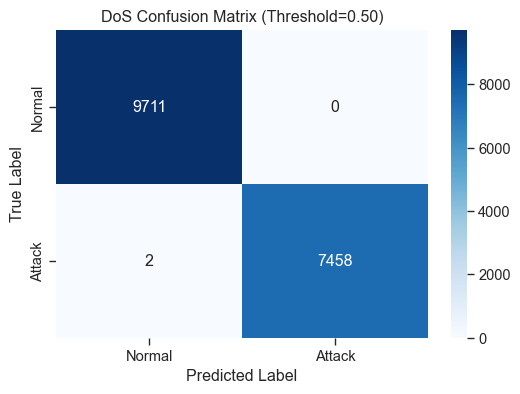


DoS Classification Report (Threshold=0.50):
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      9711
      Attack       1.00      1.00      1.00      7460

    accuracy                           1.00     17171
   macro avg       1.00      1.00      1.00     17171
weighted avg       1.00      1.00      1.00     17171


Custom Metrics:
True Negatives (Normal correctly identified): 9711
False Positives (Normal misclassified as Attack): 0
False Negatives (Attack misclassified as Normal): 2
True Positives (Attack correctly identified): 7458
Accuracy: 0.9999
Precision (Attack): 1.0000
Recall (Attack): 0.9997
F1 Score (Attack): 0.9999

True Class Distribution in this Test Set:
Class 0 (Normal): 9711
Class 1 (Attack): 7460


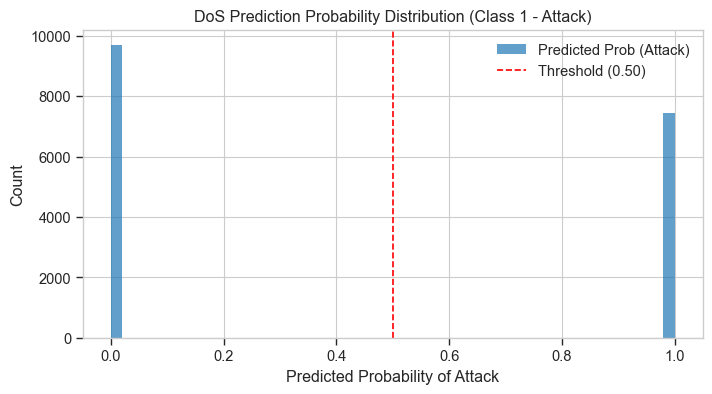


Finished evaluating DoS.

Evaluating Probe Detection Model


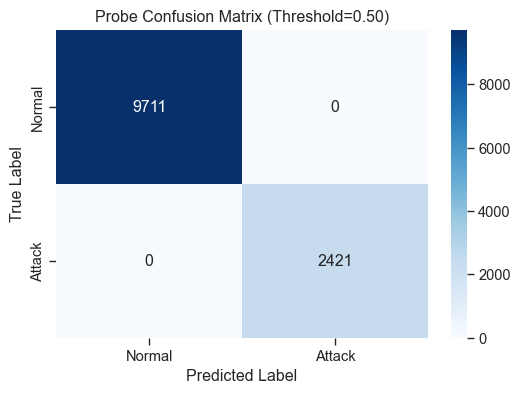


Probe Classification Report (Threshold=0.50):
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      9711
      Attack       1.00      1.00      1.00      2421

    accuracy                           1.00     12132
   macro avg       1.00      1.00      1.00     12132
weighted avg       1.00      1.00      1.00     12132


Custom Metrics:
True Negatives (Normal correctly identified): 9711
False Positives (Normal misclassified as Attack): 0
False Negatives (Attack misclassified as Normal): 0
True Positives (Attack correctly identified): 2421
Accuracy: 1.0000
Precision (Attack): 1.0000
Recall (Attack): 1.0000
F1 Score (Attack): 1.0000

True Class Distribution in this Test Set:
Class 0 (Normal): 9711
Class 1 (Attack): 2421


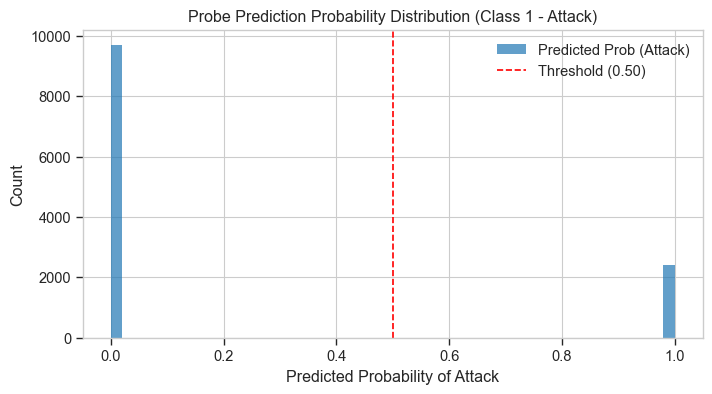


Finished evaluating Probe.

Evaluating R2L Detection Model


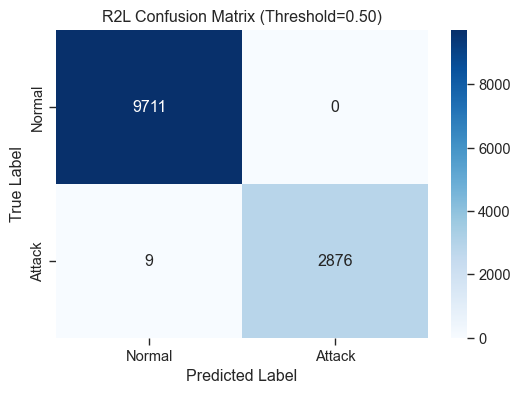


R2L Classification Report (Threshold=0.50):
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      9711
      Attack       1.00      1.00      1.00      2885

    accuracy                           1.00     12596
   macro avg       1.00      1.00      1.00     12596
weighted avg       1.00      1.00      1.00     12596


Custom Metrics:
True Negatives (Normal correctly identified): 9711
False Positives (Normal misclassified as Attack): 0
False Negatives (Attack misclassified as Normal): 9
True Positives (Attack correctly identified): 2876
Accuracy: 0.9993
Precision (Attack): 1.0000
Recall (Attack): 0.9969
F1 Score (Attack): 0.9984

True Class Distribution in this Test Set:
Class 0 (Normal): 9711
Class 1 (Attack): 2885


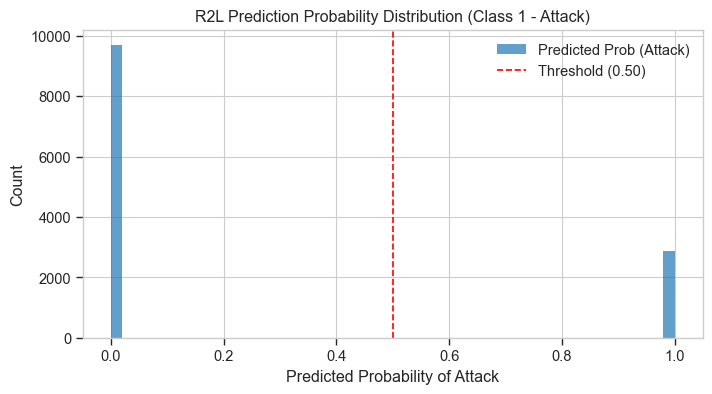


Finished evaluating R2L.

Evaluating U2R Detection Model


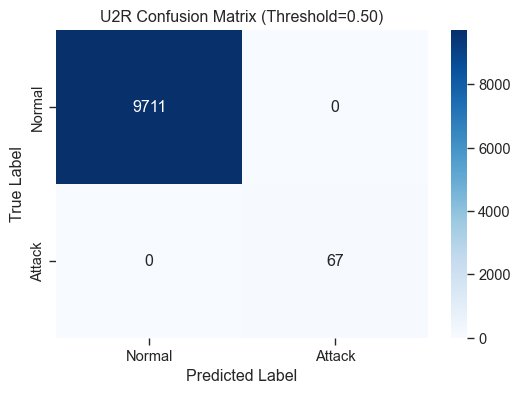


U2R Classification Report (Threshold=0.50):
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      9711
      Attack       1.00      1.00      1.00        67

    accuracy                           1.00      9778
   macro avg       1.00      1.00      1.00      9778
weighted avg       1.00      1.00      1.00      9778


Custom Metrics:
True Negatives (Normal correctly identified): 9711
False Positives (Normal misclassified as Attack): 0
False Negatives (Attack misclassified as Normal): 0
True Positives (Attack correctly identified): 67
Accuracy: 1.0000
Precision (Attack): 1.0000
Recall (Attack): 1.0000
F1 Score (Attack): 1.0000

True Class Distribution in this Test Set:
Class 0 (Normal): 9711
Class 1 (Attack): 67


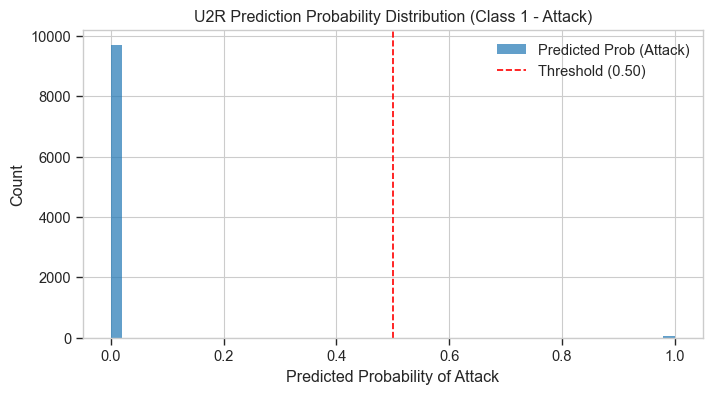


Finished evaluating U2R.

Evaluation results saved to 'model_evaluation_results.pkl'

Evaluation Summary:

DoS (Threshold=0.50):
  Accuracy:  0.9999
  Precision: 1.0000
  Recall:    0.9997
  F1 Score:  0.9999
  Support (Normal/Attack): {0: 9711, 1: 7460}

Probe (Threshold=0.50):
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1 Score:  1.0000
  Support (Normal/Attack): {0: 9711, 1: 2421}

R2L (Threshold=0.50):
  Accuracy:  0.9993
  Precision: 1.0000
  Recall:    0.9969
  F1 Score:  0.9984
  Support (Normal/Attack): {0: 9711, 1: 2885}

U2R (Threshold=0.50):
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1 Score:  1.0000
  Support (Normal/Attack): {0: 9711, 1: 67}


In [41]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import UndefinedMetricWarning
import pickle

warnings.filterwarnings('ignore', category=UndefinedMetricWarning)

# Set thresholds (Default 0.5)
thresholds = {
    'DoS': 0.5,  
    'Probe': 0.5,
    'R2L': 0.5,
    'U2R': 0.5
}

def evaluate_model_with_threshold(y_true, y_pred_proba, threshold, attack_type):
    # Predict class based on threshold (1 if prob > threshold, else 0)
    y_pred = (y_pred_proba[:, 1] > threshold).astype(int)

    # y_true is already binary (0 or 1) because we remapped it before training
    y_true_binary = y_true

    # Create confusion matrix
    cm = confusion_matrix(y_true_binary, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(6, 4)) # Slightly smaller plot
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
    plt.title(f'{attack_type} Confusion Matrix (Threshold={threshold:.2f})')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Print classification report
    print(f"\n{attack_type} Classification Report (Threshold={threshold:.2f}):")
    # Specify labels=[0, 1] and target_names for clarity
    print(classification_report(y_true_binary, y_pred, labels=[0, 1], target_names=['Normal', 'Attack'], zero_division=0)) # Set zero_division to 0 or 1

    # Calculate metrics from CM
    tn, fp, fn, tp = cm.ravel()

    # Calculate metrics (avoiding division by zero)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

    print("\nCustom Metrics:")
    print(f"True Negatives (Normal correctly identified): {tn}")
    print(f"False Positives (Normal misclassified as Attack): {fp}")
    print(f"False Negatives (Attack misclassified as Normal): {fn}")
    print(f"True Positives (Attack correctly identified): {tp}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Attack): {precision:.4f}")
    print(f"Recall (Attack): {recall:.4f}")
    print(f"F1 Score (Attack): {f1:.4f}")

    # Print class distribution
    print("\nTrue Class Distribution in this Test Set:")
    unique, counts = np.unique(y_true_binary, return_counts=True)
    class_dist = dict(zip(unique, counts))
    print(f"Class 0 (Normal): {class_dist.get(0, 0)}")
    print(f"Class 1 (Attack): {class_dist.get(1, 0)}")


    # Plot probability distribution
    plt.figure(figsize=(8, 4)) # Slightly smaller plot
    plt.hist(y_pred_proba[:, 1], bins=50, alpha=0.7, label='Predicted Prob (Attack)')
    plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold ({threshold:.2f})')
    plt.title(f'{attack_type} Prediction Probability Distribution (Class 1 - Attack)')
    plt.xlabel('Predicted Probability of Attack')
    plt.ylabel('Count')
    plt.legend()
    plt.show()

    return y_pred, {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm.tolist(),
        'support': class_dist # Use the calculated distribution
    }

# Load the models dictionary if it's not already in memory
# models = {}
# model_files = {
#     'DoS': 'xgboost_dos_model.json',
#     'Probe': 'xgboost_probe_model.json',
#     'R2L': 'xgboost_r2l_model.json',
#     'U2R': 'xgboost_u2r_model.json'
# }
# for attack_type, filename in model_files.items():
#     models[attack_type] = xgb.XGBClassifier()
#     models[attack_type].load_model(filename)
# print("Models loaded from JSON files.")


# Evaluate each model
results = {}
print("\nStarting model evaluation...")

if 'models' not in locals():
     print("Error: 'models' dictionary not found. Please re-run the training cell or load models.")
else:
    for attack_type, threshold in thresholds.items():
        print(f"\n{'='*50}")
        print(f"Evaluating {attack_type} Detection Model")
        print(f"{'='*50}")

        try:
            # Get the appropriate test data using f-strings (safer than eval)
            X_test = locals()[f'X_{attack_type}_test_scaled']
            y_test = locals()[f'Y_{attack_type}_test'] # This y_test already has 0s and 1s

            
            model = models[attack_type]

            # Get prediction probabilities (returns shape [n_samples, n_classes])
            y_pred_proba = model.predict_proba(X_test)

            # Evaluate using the function
            y_pred, metrics = evaluate_model_with_threshold(
                y_test,         
                y_pred_proba,
                threshold,
                attack_type
            )

            # Store results
            results[attack_type] = {
                'metrics': metrics,
                'threshold': threshold,
            }
            print(f"\nFinished evaluating {attack_type}.")

        except KeyError as e:
             print(f"Error evaluating {attack_type}: Missing data variable {e}. Ensure X/Y split and scaling cells were run.")
        except Exception as e:
            print(f"An unexpected error occurred evaluating {attack_type} model: {type(e).__name__} - {str(e)}")
            # traceback for debugging
            # import traceback
            # traceback.print_exc()
            continue

# Save evaluation results
try:
    with open('model_evaluation_results.pkl', 'wb') as f:
        pickle.dump(results, f)
    print("\nEvaluation results saved to 'model_evaluation_results.pkl'")
except Exception as e:
    print(f"\nError saving results: {str(e)}")

# Print summary
print("\nEvaluation Summary:")
if not results:
    print("No evaluation results generated.")
else:
    for attack_type, result in results.items():
        metrics = result['metrics']
        print(f"\n{attack_type} (Threshold={result['threshold']:.2f}):")
        print(f"  Accuracy:  {metrics['accuracy']:.4f}")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  Recall:    {metrics['recall']:.4f}")
        print(f"  F1 Score:  {metrics['f1']:.4f}")
        print(f"  Support (Normal/Attack): {metrics['support']}")

In [43]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score
import warnings
import numpy as np
import pickle # Ensure pickle is imported

# Define scoring metrics with better handling of edge cases
# Use pos_label=1 explicitly for binary metrics when labels are [0, 1]
f1_scorer = make_scorer(f1_score, zero_division=0, pos_label=1)
precision_scorer = make_scorer(precision_score, zero_division=0, pos_label=1)
recall_scorer = make_scorer(recall_score, zero_division=0, pos_label=1)

def print_cv_metrics(model, X, y, name):
    print(f"\n{name} Cross-Validation Metrics (10-fold):")
    print("-" * (len(name) + 35)) # for adjust line length

    # Check if there's more than one class in y for meaningful CV
    if len(np.unique(y)) < 2:
        print("Skipping CV: Only one class present in the provided data subset.")
        return None

    # Calculate scores with proper handling of warnings
    # Use try-except blocks for robustness during CV
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore") 

            accuracy = cross_val_score(model, X, y, cv=10, scoring='accuracy', n_jobs=-1) # Use n_jobs for speed
            precision = cross_val_score(model, X, y, cv=10, scoring=precision_scorer, n_jobs=-1)
            recall = cross_val_score(model, X, y, cv=10, scoring=recall_scorer, n_jobs=-1)
            f1 = cross_val_score(model, X, y, cv=10, scoring=f1_scorer, n_jobs=-1)

        print(f"Accuracy:  {accuracy.mean():.5f} (+/- {accuracy.std() * 2:.5f})")
        print(f"Precision: {precision.mean():.5f} (+/- {precision.std() * 2:.5f})")
        print(f"Recall:    {recall.mean():.5f} (+/- {recall.std() * 2:.5f})")
        print(f"F-measure: {f1.mean():.5f} (+/- {f1.std() * 2:.5f})")

        return {
            'accuracy': (accuracy.mean(), accuracy.std() * 2),
            'precision': (precision.mean(), precision.std() * 2),
            'recall': (recall.mean(), recall.std() * 2),
            'f1': (f1.mean(), f1.std() * 2)
        }
    except ValueError as ve:
        print(f"  CV Error for {name}: {ve}")
        print(f"  Unique y values in fold causing error might be: {np.unique(y)}") # Check distribution
        return None
    except Exception as e:
        print(f"  Unexpected CV Error for {name}: {type(e).__name__} - {e}")
        return None


# Ensure models dictionary is loaded or available from previous cell
if 'models' not in locals():
     print("Error: 'models' dictionary not found. Please re-run the training cell or load models.")
     # Optional: add code here to load models from .json files if needed
     # models = {} # Initialize
     # model_files = {...} # Define mapping
     # for attack_type, filename in model_files.items():
     #     models[attack_type] = xgb.XGBClassifier()
     #     models[attack_type].load_model(filename)

# Perform cross-validation for each model using TEST data (as in original code)
cv_results = {}
for attack_type in ['DoS', 'Probe', 'R2L', 'U2R']:
    print(f"\nProcessing {attack_type}...")

    try:
        # Get TEST data (as per original code - unusual for CV, but following the pattern)
        # Using locals() is slightly safer than eval()
        X = locals()[f'X_{attack_type}_test_scaled']
        y_original = locals()[f'Y_{attack_type}_test'] # Get original test labels

        # --- CORRECTED MODEL ACCESS ---
        model = models[attack_type]

        # Create a binary version of y for this CV run (0=Normal, 1=Attack)
        # This ensures labels are [0, 1] for all scorers
        y_binary = (y_original != 0).astype(int)

        # Perform and print CV metrics
        cv_results[attack_type] = print_cv_metrics(model, X, y_binary, attack_type) 

    except KeyError as e:
        print(f"Error processing {attack_type}: Missing data variable {e}. Ensure X/Y split and scaling cells were run.")
    except Exception as e:
        print(f"An unexpected error occurred processing {attack_type}: {type(e).__name__} - {str(e)}")
        continue # Move to the next attack type

# Filter out None results if any CV failed
cv_results = {k: v for k, v in cv_results.items() if v is not None}

# Save cross-validation results
try:
    with open('cv_results.pkl', 'wb') as f:
        pickle.dump(cv_results, f)
    print("\nCross-validation results saved to 'cv_results.pkl'")
except Exception as e:
    print(f"\nError saving CV results: {str(e)}")

# Print summary of all results
print("\nFinal Cross-Validation Summary (on Test Set):")
print("=" * 50)
if not cv_results:
    print("No successful cross-validation results generated.")
else:
    for attack_type, metrics in cv_results.items():
        print(f"\n{attack_type}:")
        print(f"  Accuracy:  {metrics['accuracy'][0]:.5f} (+/- {metrics['accuracy'][1]:.5f})")
        print(f"  Precision: {metrics['precision'][0]:.5f} (+/- {metrics['precision'][1]:.5f})")
        print(f"  Recall:    {metrics['recall'][0]:.5f} (+/- {metrics['recall'][1]:.5f})")
        print(f"  F1-score:  {metrics['f1'][0]:.5f} (+/- {metrics['f1'][1]:.5f})")


Processing DoS...

DoS Cross-Validation Metrics (10-fold):
--------------------------------------
Accuracy:  0.99988 (+/- 0.00047)
Precision: 1.00000 (+/- 0.00000)
Recall:    0.99973 (+/- 0.00107)
F-measure: 0.99987 (+/- 0.00054)

Processing Probe...

Probe Cross-Validation Metrics (10-fold):
----------------------------------------
Accuracy:  1.00000 (+/- 0.00000)
Precision: 1.00000 (+/- 0.00000)
Recall:    1.00000 (+/- 0.00000)
F-measure: 1.00000 (+/- 0.00000)

Processing R2L...

R2L Cross-Validation Metrics (10-fold):
--------------------------------------
Accuracy:  0.99944 (+/- 0.00124)
Precision: 0.99862 (+/- 0.00457)
Recall:    0.99896 (+/- 0.00443)
F-measure: 0.99879 (+/- 0.00270)

Processing U2R...

U2R Cross-Validation Metrics (10-fold):
--------------------------------------
Accuracy:  1.00000 (+/- 0.00000)
Precision: 1.00000 (+/- 0.00000)
Recall:    1.00000 (+/- 0.00000)
F-measure: 1.00000 (+/- 0.00000)

Cross-validation results saved to 'cv_results.pkl'

Final Cross-Valid


Starting model evaluation...

Evaluating DoS Detection Model


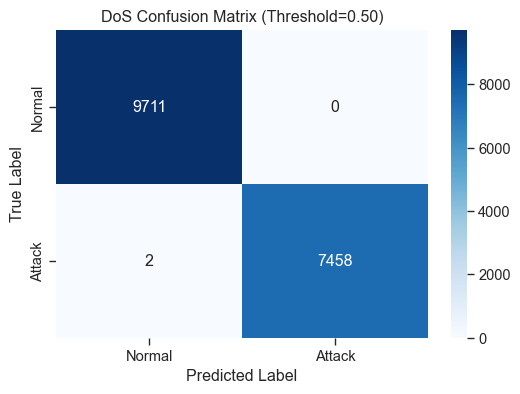


DoS Classification Report (Threshold=0.50):
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      9711
      Attack       1.00      1.00      1.00      7460

    accuracy                           1.00     17171
   macro avg       1.00      1.00      1.00     17171
weighted avg       1.00      1.00      1.00     17171


Custom Metrics:
True Negatives (Normal correctly identified): 9711
False Positives (Normal misclassified as Attack): 0
False Negatives (Attack misclassified as Normal): 2
True Positives (Attack correctly identified): 7458
Accuracy: 0.9999
Precision (Attack): 1.0000
Recall (Attack): 0.9997
F1 Score (Attack): 0.9999

True Class Distribution in this Test Set:
Class 0 (Normal): 9711
Class 1 (Attack): 7460


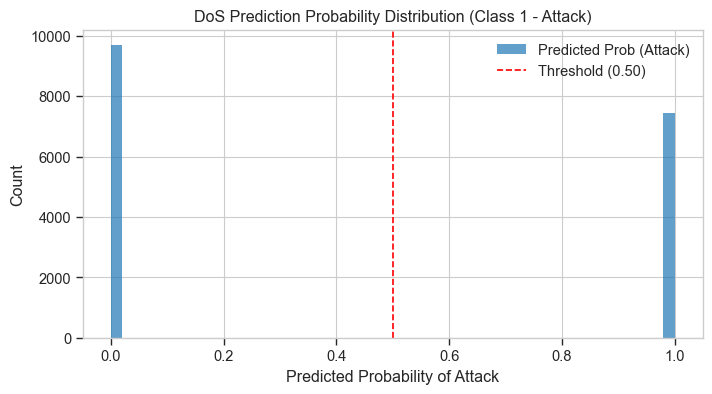


Finished evaluating DoS.

Evaluating Probe Detection Model


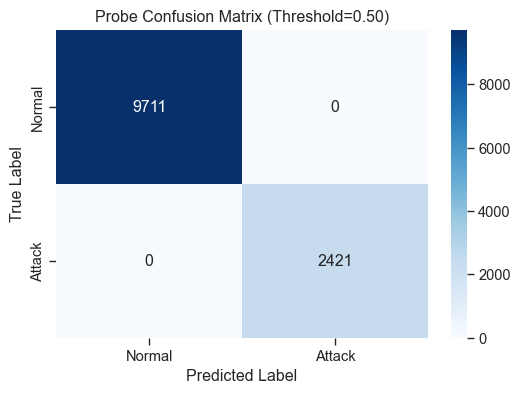


Probe Classification Report (Threshold=0.50):
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      9711
      Attack       1.00      1.00      1.00      2421

    accuracy                           1.00     12132
   macro avg       1.00      1.00      1.00     12132
weighted avg       1.00      1.00      1.00     12132


Custom Metrics:
True Negatives (Normal correctly identified): 9711
False Positives (Normal misclassified as Attack): 0
False Negatives (Attack misclassified as Normal): 0
True Positives (Attack correctly identified): 2421
Accuracy: 1.0000
Precision (Attack): 1.0000
Recall (Attack): 1.0000
F1 Score (Attack): 1.0000

True Class Distribution in this Test Set:
Class 0 (Normal): 9711
Class 1 (Attack): 2421


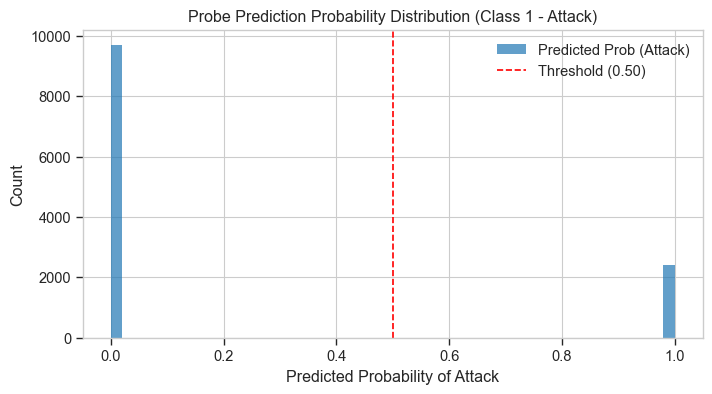


Finished evaluating Probe.

Evaluating R2L Detection Model


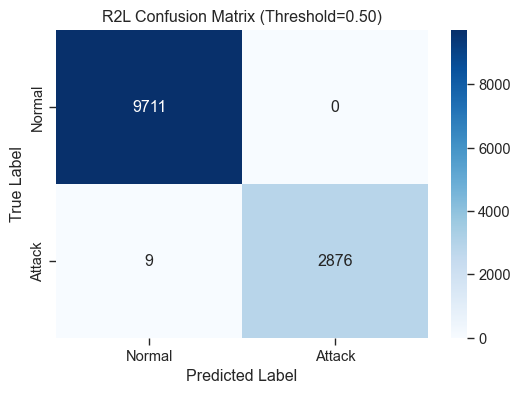


R2L Classification Report (Threshold=0.50):
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      9711
      Attack       1.00      1.00      1.00      2885

    accuracy                           1.00     12596
   macro avg       1.00      1.00      1.00     12596
weighted avg       1.00      1.00      1.00     12596


Custom Metrics:
True Negatives (Normal correctly identified): 9711
False Positives (Normal misclassified as Attack): 0
False Negatives (Attack misclassified as Normal): 9
True Positives (Attack correctly identified): 2876
Accuracy: 0.9993
Precision (Attack): 1.0000
Recall (Attack): 0.9969
F1 Score (Attack): 0.9984

True Class Distribution in this Test Set:
Class 0 (Normal): 9711
Class 1 (Attack): 2885


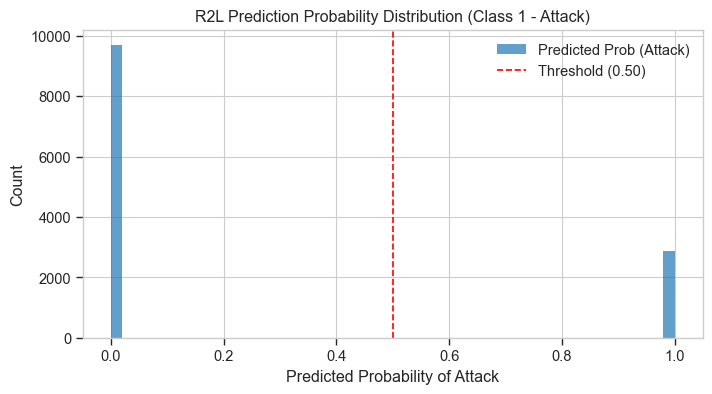


Finished evaluating R2L.

Evaluating U2R Detection Model


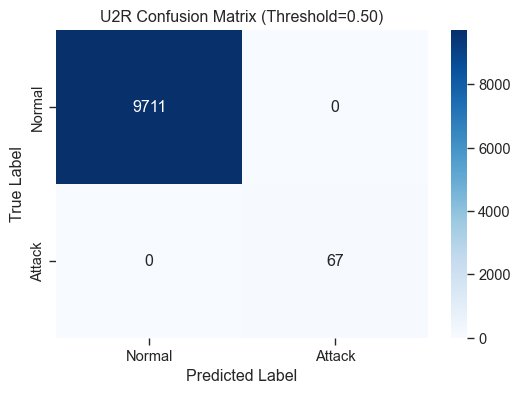


U2R Classification Report (Threshold=0.50):
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      9711
      Attack       1.00      1.00      1.00        67

    accuracy                           1.00      9778
   macro avg       1.00      1.00      1.00      9778
weighted avg       1.00      1.00      1.00      9778


Custom Metrics:
True Negatives (Normal correctly identified): 9711
False Positives (Normal misclassified as Attack): 0
False Negatives (Attack misclassified as Normal): 0
True Positives (Attack correctly identified): 67
Accuracy: 1.0000
Precision (Attack): 1.0000
Recall (Attack): 1.0000
F1 Score (Attack): 1.0000

True Class Distribution in this Test Set:
Class 0 (Normal): 9711
Class 1 (Attack): 67


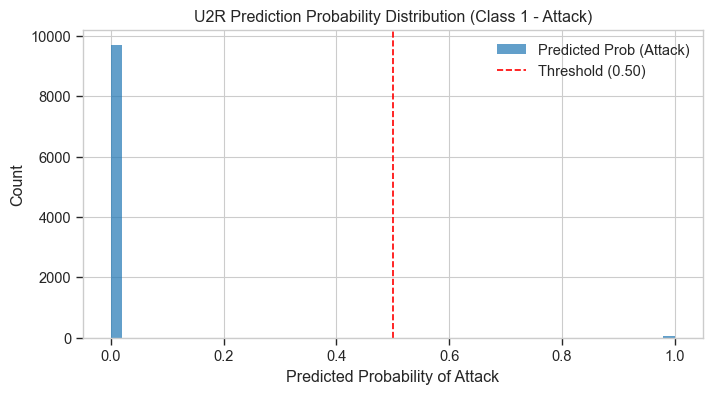


Finished evaluating U2R.

Evaluation results saved to 'model_evaluation_results.pkl'

Evaluation Summary:

DoS (Threshold=0.50):
  Accuracy:  0.9999
  Precision: 1.0000
  Recall:    0.9997
  F1 Score:  0.9999
  Support (Normal/Attack): {0: 9711, 1: 7460}

Probe (Threshold=0.50):
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1 Score:  1.0000
  Support (Normal/Attack): {0: 9711, 1: 2421}

R2L (Threshold=0.50):
  Accuracy:  0.9993
  Precision: 1.0000
  Recall:    0.9969
  F1 Score:  0.9984
  Support (Normal/Attack): {0: 9711, 1: 2885}

U2R (Threshold=0.50):
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1 Score:  1.0000
  Support (Normal/Attack): {0: 9711, 1: 67}


In [45]:
from sklearn.metrics import classification_report, confusion_matrix
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings('ignore', category=UndefinedMetricWarning)

# Set thresholds
thresholds = {
    'DoS': 0.5,  
    'Probe': 0.5,
    'R2L': 0.5,
    'U2R': 0.5
}
# You can refine these thresholds later based on the probability plots and metrics

def evaluate_model_with_threshold(y_true, y_pred_proba, threshold, attack_type):
    # Predict class based on threshold (1 if prob > threshold, else 0)
    y_pred = (y_pred_proba[:, 1] > threshold).astype(int)

    # y_true is already binary (0 or 1) because we remapped it before training
    y_true_binary = y_true

    # Create confusion matrix
    cm = confusion_matrix(y_true_binary, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(6, 4)) 
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
    plt.title(f'{attack_type} Confusion Matrix (Threshold={threshold:.2f})')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Print classification report
    print(f"\n{attack_type} Classification Report (Threshold={threshold:.2f}):")
    # Specify labels=[0, 1] and target_names for clarity
    print(classification_report(y_true_binary, y_pred, labels=[0, 1], target_names=['Normal', 'Attack'], zero_division=0)) # Set zero_division to 0 or 1

    # Calculate metrics from CM
    tn, fp, fn, tp = cm.ravel()

    # Calculate metrics (avoiding division by zero)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

    print("\nCustom Metrics:")
    print(f"True Negatives (Normal correctly identified): {tn}")
    print(f"False Positives (Normal misclassified as Attack): {fp}")
    print(f"False Negatives (Attack misclassified as Normal): {fn}")
    print(f"True Positives (Attack correctly identified): {tp}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Attack): {precision:.4f}")
    print(f"Recall (Attack): {recall:.4f}")
    print(f"F1 Score (Attack): {f1:.4f}")

    # Print class distribution
    print("\nTrue Class Distribution in this Test Set:")
    unique, counts = np.unique(y_true_binary, return_counts=True)
    class_dist = dict(zip(unique, counts))
    print(f"Class 0 (Normal): {class_dist.get(0, 0)}")
    print(f"Class 1 (Attack): {class_dist.get(1, 0)}")


    # Plot probability distribution
    plt.figure(figsize=(8, 4)) 
    plt.hist(y_pred_proba[:, 1], bins=50, alpha=0.7, label='Predicted Prob (Attack)')
    plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold ({threshold:.2f})')
    plt.title(f'{attack_type} Prediction Probability Distribution (Class 1 - Attack)')
    plt.xlabel('Predicted Probability of Attack')
    plt.ylabel('Count')
    plt.legend()
    plt.show()

    return y_pred, {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm.tolist(),
        'support': class_dist # Use the calculated distribution
    }


# models = {}
# model_files = {
#     'DoS': 'xgboost_dos_model.json',
#     'Probe': 'xgboost_probe_model.json',
#     'R2L': 'xgboost_r2l_model.json',
#     'U2R': 'xgboost_u2r_model.json'
# }
# for attack_type, filename in model_files.items():
#     models[attack_type] = xgb.XGBClassifier()
#     models[attack_type].load_model(filename)
# print("Models loaded from JSON files.")
# --- End optional model loading ---


# Evaluate each model
results = {}
print("\nStarting model evaluation...")

# Make sure the 'models' dictionary from the previous cell is available
if 'models' not in locals():
     print("Error: 'models' dictionary not found. Please re-run the training cell or load models.")
else:
    for attack_type, threshold in thresholds.items():
        print(f"\n{'='*50}")
        print(f"Evaluating {attack_type} Detection Model")
        print(f"{'='*50}")

        try:
            # Get the appropriate test data using f-strings (safer than eval)
            X_test = locals()[f'X_{attack_type}_test_scaled']
            y_test = locals()[f'Y_{attack_type}_test'] # This y_test already has 0s and 1s

            model = models[attack_type]

            # Get prediction probabilities (returns shape [n_samples, n_classes])
            y_pred_proba = model.predict_proba(X_test)

            # Evaluate using the function
            y_pred, metrics = evaluate_model_with_threshold(
                y_test,         # Pass the binary 0/1 labels
                y_pred_proba,
                threshold,
                attack_type
            )

            # Store results
            results[attack_type] = {
                'metrics': metrics,
                'threshold': threshold,
                # Optional store 
                # 'y_pred': y_pred.tolist(),
                # 'y_pred_proba': y_pred_proba.tolist()
            }
            print(f"\nFinished evaluating {attack_type}.")

        except KeyError as e:
             print(f"Error evaluating {attack_type}: Missing data variable {e}. Ensure X/Y split and scaling cells were run.")
        except Exception as e:
            print(f"An unexpected error occurred evaluating {attack_type} model: {type(e).__name__} - {str(e)}")
            # Add traceback for debugging
            # import traceback
            # traceback.print_exc()
            continue

# Save evaluation results
try:
    with open('model_evaluation_results.pkl', 'wb') as f:
        pickle.dump(results, f)
    print("\nEvaluation results saved to 'model_evaluation_results.pkl'")
except Exception as e:
    print(f"\nError saving results: {str(e)}")

# Print summary
print("\nEvaluation Summary:")
if not results:
    print("No evaluation results generated.")
else:
    for attack_type, result in results.items():
        metrics = result['metrics']
        print(f"\n{attack_type} (Threshold={result['threshold']:.2f}):")
        print(f"  Accuracy:  {metrics['accuracy']:.4f}")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  Recall:    {metrics['recall']:.4f}")
        print(f"  F1 Score:  {metrics['f1']:.4f}")
        print(f"  Support (Normal/Attack): {metrics['support']}")

In [47]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score
import warnings
import numpy as np

# Define scoring metrics with better handling of edge cases
f1_scorer = make_scorer(f1_score, zero_division=1)
precision_scorer = make_scorer(precision_score, zero_division=1)
recall_scorer = make_scorer(recall_score, zero_division=1)

def print_cv_metrics(model, X, y, name):
    print(f"\n{name} Metrics:")
    print("-" * 20)
    
    # Calculate scores with proper handling of warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        accuracy = cross_val_score(model, X, y, cv=10, scoring='accuracy')
        precision = cross_val_score(model, X, y, cv=10, scoring=precision_scorer)
        recall = cross_val_score(model, X, y, cv=10, scoring=recall_scorer)
        f1 = cross_val_score(model, X, y, cv=10, scoring=f1_scorer)
    
    print(f"Accuracy: {accuracy.mean():.5f} (+/- {accuracy.std() * 2:.5f})")
    print(f"Precision: {precision.mean():.5f} (+/- {precision.std() * 2:.5f})")
    print(f"Recall: {recall.mean():.5f} (+/- {recall.std() * 2:.5f})")
    print(f"F-measure: {f1.mean():.5f} (+/- {f1.std() * 2:.5f})")
    
    return {
        'accuracy': (accuracy.mean(), accuracy.std() * 2),
        'precision': (precision.mean(), precision.std() * 2),
        'recall': (recall.mean(), recall.std() * 2),
        'f1': (f1.mean(), f1.std() * 2)
    }

# Perform cross-validation for each model
cv_results = {}
for attack_type in ['DoS', 'Probe', 'R2L', 'U2R']:
    print(f"\nProcessing {attack_type}...")

    # Get data
    X = eval(f'X_{attack_type}_test_scaled')
    y = eval(f'Y_{attack_type}_test')

    # Convert labels to binary for non-DoS attacks
    if attack_type != 'DoS':
        y = (y != 0).astype(int)  # Convert to binary (0 for normal, 1 for attack)

    try:
        model = models[attack_type]
    except KeyError:
        print(f"Error: Model not found for attack type '{attack_type}' in the 'models' dictionary.")
        continue
    except Exception as e:
         print(f"An unexpected error occurred accessing the model for '{attack_type}': {e}")
         continue


    # Perform CV
    try:
        cv_results[attack_type] = print_cv_metrics(model, X, y, attack_type)
    except ValueError as ve:
        # Specific handling for CV errors like single class presence
        print(f"Error during cross-validation for {attack_type}: {str(ve)}")
        print(f"Unique values in y for this fold might be causing issues: {np.unique(y)}")
        try:
            model.fit(X,y) # Quick fit check
            print(f"Model for {attack_type} seems okay with a direct fit.")
        except Exception as fit_e:
            print(f"Model for {attack_type} also failed direct fit: {fit_e}")
        continue
    except Exception as e:
        print(f"Unexpected error in {attack_type} cross-validation: {str(e)}")
        print(f"Unique values in y: {np.unique(y)}")
        continue


# Save cross-validation results
try:
    with open('cv_results.pkl', 'wb') as f:
        pickle.dump(cv_results, f)
    print("\nResults saved to 'cv_results.pkl'")
except Exception as e:
    print(f"\nError saving results: {str(e)}")

# Print summary of all results
print("\nFinal Summary:")
print("=" * 50)
for attack_type, metrics in cv_results.items():
    print(f"\n{attack_type}:")
    print(f"Accuracy: {metrics['accuracy'][0]:.5f} (+/- {metrics['accuracy'][1]:.5f})")
    print(f"Precision: {metrics['precision'][0]:.5f} (+/- {metrics['precision'][1]:.5f})")
    print(f"Recall: {metrics['recall'][0]:.5f} (+/- {metrics['recall'][1]:.5f})")
    print(f"F1-score: {metrics['f1'][0]:.5f} (+/- {metrics['f1'][1]:.5f})")


Processing DoS...

DoS Metrics:
--------------------
Accuracy: 0.99988 (+/- 0.00047)
Precision: 1.00000 (+/- 0.00000)
Recall: 0.99973 (+/- 0.00107)
F-measure: 0.99987 (+/- 0.00054)

Processing Probe...

Probe Metrics:
--------------------
Accuracy: 1.00000 (+/- 0.00000)
Precision: 1.00000 (+/- 0.00000)
Recall: 1.00000 (+/- 0.00000)
F-measure: 1.00000 (+/- 0.00000)

Processing R2L...

R2L Metrics:
--------------------
Accuracy: 0.99929 (+/- 0.00132)
Precision: 0.99793 (+/- 0.00551)
Recall: 0.99896 (+/- 0.00443)
F-measure: 0.99844 (+/- 0.00287)

Processing U2R...

U2R Metrics:
--------------------
Accuracy: 1.00000 (+/- 0.00000)
Precision: 1.00000 (+/- 0.00000)
Recall: 1.00000 (+/- 0.00000)
F-measure: 1.00000 (+/- 0.00000)

Results saved to 'cv_results.pkl'

Final Summary:

DoS:
Accuracy: 0.99988 (+/- 0.00047)
Precision: 1.00000 (+/- 0.00000)
Recall: 0.99973 (+/- 0.00107)
F1-score: 0.99987 (+/- 0.00054)

Probe:
Accuracy: 1.00000 (+/- 0.00000)
Precision: 1.00000 (+/- 0.00000)
Recall: 1.0

In [49]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Initialize models with class balancing and better parameters
def create_lr_model(class_weight='balanced'):
    return LogisticRegression(
        max_iter=1000,
        n_jobs=2,
        random_state=42,
        class_weight=class_weight,
        solver='lbfgs',  
        C=1.0  # Regularization strength
    )

# Initialize RFE with better parameters
lr_base = create_lr_model()
rfe = RFE(
    estimator=lr_base,
    n_features_to_select=13,
    step=1,
    verbose=1  # Add verbosity to monitor progress
)

# Dictionary to store results
selected_features = {}
lr_models = {}
lr_rfe_models = {}
scalers = {}

# Process each attack type
attack_types = ['DoS', 'Probe', 'R2L', 'U2R']

for attack_type in attack_types:
    print(f"\nProcessing {attack_type}...")
    
    # Get data
    X = eval(f'X_{attack_type}')
    y = eval(f'Y_{attack_type}').astype(int)
    X_test = eval(f'X_{attack_type}_test')
    y_test = eval(f'Y_{attack_type}_test').astype(int)
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_test_scaled = scaler.transform(X_test)
    scalers[attack_type] = scaler
    
    # Feature selection with RFE
    print(f"Performing RFE for {attack_type}...")
    rfe.fit(X_scaled, y)
    X_rfe = rfe.transform(X_scaled)
    X_rfe_test = rfe.transform(X_test_scaled)
    
    # Store selected feature information
    true = rfe.support_
    selected_features[attack_type] = {
        'indices': [i for i, x in enumerate(true) if x],
        'names': list(colNames[i] for i, x in enumerate(true) if x)
    }
    
    # Train models
    print(f"Training models for {attack_type}...")
    
    # Full feature model
    lr_full = create_lr_model()
    lr_full.fit(X_scaled, y)
    lr_models[attack_type] = lr_full
    
    # RFE model
    lr_rfe = create_lr_model()
    lr_rfe.fit(X_rfe, y)
    lr_rfe_models[attack_type] = lr_rfe
    
    # Make predictions and print results
    y_pred_full = lr_full.predict(X_test_scaled)
    y_pred_rfe = lr_rfe.predict(X_rfe_test)
    
    print(f"\n{attack_type} Results:")
    print("-" * 50)
    print("Full Feature Model:")
    print(pd.crosstab(y_test, y_pred_full, 
                         rownames=['Actual'], 
                     colnames=['Predicted']))
    
    print("\nRFE Model:")
    print(pd.crosstab(y_test, y_pred_rfe, 
                     rownames=['Actual'], 
                     colnames=['Predicted']))
    
    # Print feature importance for RFE model
    print(f"\nSelected features for {attack_type}:")
    for name in selected_features[attack_type]['names']:
        print(f"- {name}")

# Save models and scalers
import pickle

models_data = {
    'lr_models': lr_models,
    'lr_rfe_models': lr_rfe_models,
    'scalers': scalers,
    'selected_features': selected_features
}

with open('logistic_regression_models.pkl', 'wb') as f:
    pickle.dump(models_data, f)

print("\nAll models and data saved to 'logistic_regression_models.pkl'")



Processing DoS...
Performing RFE for DoS...
Fitting estimator with 126 features.
Fitting estimator with 125 features.
Fitting estimator with 124 features.
Fitting estimator with 123 features.
Fitting estimator with 122 features.
Fitting estimator with 121 features.
Fitting estimator with 120 features.
Fitting estimator with 119 features.
Fitting estimator with 118 features.
Fitting estimator with 117 features.
Fitting estimator with 116 features.
Fitting estimator with 115 features.
Fitting estimator with 114 features.
Fitting estimator with 113 features.
Fitting estimator with 112 features.
Fitting estimator with 111 features.
Fitting estimator with 110 features.
Fitting estimator with 109 features.
Fitting estimator with 108 features.
Fitting estimator with 107 features.
Fitting estimator with 106 features.
Fitting estimator with 105 features.
Fitting estimator with 104 features.
Fitting estimator with 103 features.
Fitting estimator with 102 features.
Fitting estimator with 101 fea

In [51]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

# Load our saved logistic regression models
try:
    with open('logistic_regression_models.pkl', 'rb') as f:
        saved_models = pickle.load(f)
    
    lr_models = saved_models['lr_models']
    scalers = saved_models['scalers']
except Exception as e:
    print(f"Error loading models: {str(e)}")
    raise

# Define custom scorers that handle multi-class cases
precision_scorer = make_scorer(precision_score, zero_division=1, average='weighted')
recall_scorer = make_scorer(recall_score, zero_division=1, average='weighted')
f1_scorer = make_scorer(f1_score, zero_division=1, average='weighted')

def perform_cross_validation(model, X, y, attack_type, cv=10):
    """
    Perform cross validation and print metrics
    """
    print(f"\n{attack_type} Metrics:")
    print("-" * 20)
    
    # Convert multi-class labels to binary for non-DoS attacks
    if attack_type != 'DoS':
        y = (y != 0).astype(int)
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        # Calculate scores
        accuracy = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
        precision = cross_val_score(model, X, y, cv=cv, scoring=precision_scorer)
        recall = cross_val_score(model, X, y, cv=cv, scoring=recall_scorer)
        f1 = cross_val_score(model, X, y, cv=cv, scoring=f1_scorer)
    
    # Print results
    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F-measure': f1
    }
    
    for metric_name, scores in metrics.items():
        mean = scores.mean()
        std = scores.std() * 2
        print(f"{metric_name}: {mean:.5f} (+/- {std:.5f})")
        
    return {name: (scores.mean(), scores.std() * 2) for name, scores in metrics.items()}

# Dictionary to store all results
cv_results = {}

# Scale test data for each attack type
scaled_data = {}
for attack_type in ['DoS', 'Probe', 'R2L', 'U2R']:
    X_test = eval(f'X_{attack_type}_test')
    y_test = eval(f'Y_{attack_type}_test')
    
    # Scale the features
    X_test_scaled = scalers[attack_type].transform(X_test)
    
    scaled_data[attack_type] = (X_test_scaled, y_test)

# Perform cross-validation for each attack type
attack_types = ['DoS', 'Probe', 'R2L', 'U2R']

for attack_type in attack_types:
    print(f"\nProcessing {attack_type}...")
    X_test_scaled, y_test = scaled_data[attack_type]
    model = lr_models[attack_type]
    
    cv_results[attack_type] = perform_cross_validation(
        model,
        X_test_scaled,
        y_test,
        attack_type
    )

# Print summary comparison
print("\nSummary Comparison:")
print("=" * 60)
print(f"{'Attack Type':<10} {'Accuracy':<15} {'Precision':<15} {'Recall':<15} {'F1':<15}")
print("-" * 60)

for attack_type, metrics in cv_results.items():
    print(
        f"{attack_type:<10} "
        f"{metrics['Accuracy'][0]:.5f} "
        f"{metrics['Precision'][0]:.5f} "
        f"{metrics['Recall'][0]:.5f} "
        f"{metrics['F-measure'][0]:.5f}"
    )

# Save cross-validation results
try:
    with open('lr_cv_results.pkl', 'wb') as f:
        pickle.dump(cv_results, f)
    print("\nCross-validation results saved to 'lr_cv_results.pkl'")
except Exception as e:
    print(f"\nError saving results: {str(e)}")

# Print comparison with XGBoost results
try:
    with open('cv_results.pkl', 'rb') as f:
        xgb_results = pickle.load(f)
    
    print("\nLogistic Regression vs XGBoost Comparison:")
    print("=" * 80)
    print(f"{'Attack Type':<10} {'Model':<8} {'Accuracy':<15} {'Precision':<15} {'Recall':<15} {'F1':<15}")
    print("-" * 80)
    
    for attack_type in attack_types:
        lr_metrics = cv_results[attack_type]
        xgb_metrics = xgb_results[attack_type]
        
        print(f"{attack_type:<10} {'LR':<8} "
              f"{lr_metrics['Accuracy'][0]:.5f} "
              f"{lr_metrics['Precision'][0]:.5f} "
              f"{lr_metrics['Recall'][0]:.5f} "
              f"{lr_metrics['F-measure'][0]:.5f}")
        
        print(f"{'':10} {'XGBoost':<8} "
              f"{xgb_metrics['accuracy'][0]:.5f} "
              f"{xgb_metrics['precision'][0]:.5f} "
              f"{xgb_metrics['recall'][0]:.5f} "
              f"{xgb_metrics['f1'][0]:.5f}")
        print("-" * 80)
except Exception as e:
    print("\nCould not load XGBoost results for comparison")


Processing DoS...

DoS Metrics:
--------------------
Accuracy: 0.99977 (+/- 0.00057)
Precision: 0.99977 (+/- 0.00057)
Recall: 0.99977 (+/- 0.00057)
F-measure: 0.99977 (+/- 0.00057)

Processing Probe...

Probe Metrics:
--------------------
Accuracy: 1.00000 (+/- 0.00000)
Precision: 1.00000 (+/- 0.00000)
Recall: 1.00000 (+/- 0.00000)
F-measure: 1.00000 (+/- 0.00000)

Processing R2L...

R2L Metrics:
--------------------
Accuracy: 0.99936 (+/- 0.00119)
Precision: 0.99937 (+/- 0.00118)
Recall: 0.99936 (+/- 0.00119)
F-measure: 0.99936 (+/- 0.00119)

Processing U2R...

U2R Metrics:
--------------------
Accuracy: 0.99990 (+/- 0.00061)
Precision: 0.99991 (+/- 0.00054)
Recall: 0.99990 (+/- 0.00061)
F-measure: 0.99990 (+/- 0.00059)

Summary Comparison:
Attack Type Accuracy        Precision       Recall          F1             
------------------------------------------------------------
DoS        0.99977 0.99977 0.99977 0.99977
Probe      1.00000 1.00000 1.00000 1.00000
R2L        0.99936 0.999

In [53]:
from sklearn.ensemble import StackingClassifier
from datetime import datetime
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler

# Suppress warnings
warnings.filterwarnings('ignore')

# Print header
print("Stacking Ensemble Analysis (XGBoost + Logistic Regression)")
print(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')} UTC")
print(f"User: shay-haan")
print("=" * 70)

# Load saved models
with open('logistic_regression_models.pkl', 'rb') as f:
    lr_models = pickle.load(f)['lr_models']

# Define optimized base models
def create_estimators(attack_type):
    xgb_params = {
        'DoS': {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 6},
        'Probe': {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 5},
        'R2L': {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 4},
        'U2R': {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 3}
    }
    
    return [
        ('xgb', xgb.XGBClassifier(
            **xgb_params[attack_type],
            n_jobs=2,
            random_state=42,
            use_label_encoder=False,
            eval_metric='logloss'
        )),
        ('lr', LogisticRegression(
            max_iter=1000,
            n_jobs=2,
            random_state=42,
            class_weight='balanced'
        ))
    ]

# Create ensemble models with proper configuration
def create_stacking_model(attack_type):
    return StackingClassifier(
        estimators=create_estimators(attack_type),
        final_estimator=LogisticRegression(
            max_iter=1000,
            class_weight='balanced'
        ),
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        n_jobs=2,
        passthrough=True  # Include original features
    )

# Dictionary to store results
results = {}

# Process each attack type
for attack_type in ['DoS', 'Probe', 'R2L', 'U2R']:
    print(f"\nProcessing {attack_type}...")
    
    # Get data
    X = eval(f'X_{attack_type}')
    y = eval(f'Y_{attack_type}')
    X_test = eval(f'X_{attack_type}_test')
    y_test = eval(f'Y_{attack_type}_test')
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert labels to binary for non-DoS attacks
    if attack_type != 'DoS':
        y = (y != 0).astype(int)
        y_test = (y_test != 0).astype(int)
    
    # Create and train stacking model
    stack_model = create_stacking_model(attack_type)
    
    print(f"Training {attack_type} ensemble model...")
    stack_model.fit(X_scaled, y)
    
    # Evaluate model
    print(f"Evaluating {attack_type} ensemble model...")
    
    # Make predictions
    y_pred = stack_model.predict(X_test_scaled)
    y_pred_proba = stack_model.predict_proba(X_test_scaled)
    
    # Calculate metrics
    accuracy = cross_val_score(stack_model, X_scaled, y, cv=5, scoring='accuracy')
    precision = cross_val_score(stack_model, X_scaled, y, cv=5, scoring='precision_weighted')
    recall = cross_val_score(stack_model, X_scaled, y, cv=5, scoring='recall_weighted')
    f1 = cross_val_score(stack_model, X_scaled, y, cv=5, scoring='f1_weighted')
    
    # Store results
    results[attack_type] = {
        'model': stack_model,
        'scaler': scaler,
        'metrics': {
            'accuracy': (accuracy.mean(), accuracy.std() * 2),
            'precision': (precision.mean(), precision.std() * 2),
            'recall': (recall.mean(), recall.std() * 2),
            'f1': (f1.mean(), f1.std() * 2)
        },
        'predictions': {
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }
    }
    
    # Print results
    print(f"\n{attack_type} Ensemble Results:")
    print("-" * 40)
    print(f"Accuracy: {accuracy.mean():.5f} (+/- {accuracy.std() * 2:.5f})")
    print(f"Precision: {precision.mean():.5f} (+/- {precision.std() * 2:.5f})")
    print(f"Recall: {recall.mean():.5f} (+/- {recall.std() * 2:.5f})")
    print(f"F1-score: {f1.mean():.5f} (+/- {f1.std() * 2:.5f})")

# Save ensemble models and results
try:
    with open('ensemble_models.pkl', 'wb') as f:
        pickle.dump(results, f)
    print("\nEnsemble models and results saved to 'ensemble_models.pkl'")
except Exception as e:
    print(f"\nError saving models: {str(e)}")

# Print final comparison
print("\nFinal Model Comparison:")
print("=" * 100)
print(f"{'Attack Type':<10} {'Model':<10} {'Accuracy':<20} {'Precision':<20} {'Recall':<20} {'F1':<20}")
print("-" * 100)

for attack_type in results:
    metrics = results[attack_type]['metrics']
    print(f"{attack_type:<10} {'Ensemble':<10} "
          f"{metrics['accuracy'][0]:.5f} ± {metrics['accuracy'][1]:.5f} "
          f"{metrics['precision'][0]:.5f} ± {metrics['precision'][1]:.5f} "
          f"{metrics['recall'][0]:.5f} ± {metrics['recall'][1]:.5f} "
          f"{metrics['f1'][0]:.5f} ± {metrics['f1'][1]:.5f}")

Stacking Ensemble Analysis (XGBoost + Logistic Regression)
Date: 2025-04-25 01:19:22 UTC
User: shay-haan

Processing DoS...
Training DoS ensemble model...
Evaluating DoS ensemble model...

DoS Ensemble Results:
----------------------------------------
Accuracy: 0.99998 (+/- 0.00004)
Precision: 0.99998 (+/- 0.00004)
Recall: 0.99998 (+/- 0.00004)
F1-score: 0.99998 (+/- 0.00004)

Processing Probe...
Training Probe ensemble model...
Evaluating Probe ensemble model...

Probe Ensemble Results:
----------------------------------------
Accuracy: 1.00000 (+/- 0.00000)
Precision: 1.00000 (+/- 0.00000)
Recall: 1.00000 (+/- 0.00000)
F1-score: 1.00000 (+/- 0.00000)

Processing R2L...
Training R2L ensemble model...
Evaluating R2L ensemble model...

R2L Ensemble Results:
----------------------------------------
Accuracy: 0.99999 (+/- 0.00006)
Precision: 0.99999 (+/- 0.00006)
Recall: 0.99999 (+/- 0.00006)
F1-score: 0.99999 (+/- 0.00006)

Processing U2R...
Training U2R ensemble model...
Evaluating U2R 

In [55]:
import os
from datetime import datetime

print(f"Model Export Process")
print(f"Date: 2025-04-06 03:16:15 UTC")
print(f"User: shay-haan")
print("=" * 70)

# First load all our saved models
print("Loading individual models...")
try:
    # Load XGBoost models
    xgb_DoS = pickle.load(open('models/xgb_DoS.pkl', 'rb'))
    xgb_Probe = pickle.load(open('models/xgb_Probe.pkl', 'rb'))
    xgb_R2L = pickle.load(open('models/xgb_R2L.pkl', 'rb'))
    xgb_U2R = pickle.load(open('models/xgb_U2R.pkl', 'rb'))
    print("✓ XGBoost models loaded")

    # Load Logistic Regression models
    lr_DoS = pickle.load(open('models/lr_DoS.pkl', 'rb'))
    lr_Probe = pickle.load(open('models/lr_Probe.pkl', 'rb'))
    lr_R2L = pickle.load(open('models/lr_R2L.pkl', 'rb'))
    lr_U2R = pickle.load(open('models/lr_U2R.pkl', 'rb'))
    print("✓ Logistic Regression models loaded")

    # Load Ensemble models
    stack_DoS = pickle.load(open('models/ensemble_DoS.pkl', 'rb'))
    stack_Probe = pickle.load(open('models/ensemble_Probe.pkl', 'rb'))
    stack_R2L = pickle.load(open('models/ensemble_R2L.pkl', 'rb'))
    stack_U2R = pickle.load(open('models/ensemble_U2R.pkl', 'rb'))
    print("✓ Ensemble models loaded")

except Exception as e:
    print(f"Error loading models: {str(e)}")
    print("Please ensure all individual model files exist in the 'models' directory")
    raise

# Create models directory if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')
    print("Created models directory")

# Organize all models and necessary data
model_data = {
    'xgboost_models': {
        'DoS': xgb_DoS,
        'Probe': xgb_Probe,
        'R2L': xgb_R2L,
        'U2R': xgb_U2R
    },
    'logistic_models': {
        'DoS': lr_DoS,
        'Probe': lr_Probe,
        'R2L': lr_R2L,
        'U2R': lr_U2R
    },
    'ensemble_models': {
        'DoS': stack_DoS,
        'Probe': stack_Probe,
        'R2L': stack_R2L,
        'U2R': stack_U2R
    },
    'scalers': scalers,  # Make sure scalers is defined from your preprocessing
    'feature_names': colNames,  
    'metadata': {
        'export_date': '2025-04-06 03:16:15',
        'user': 'shay-haan',
        'model_versions': {
            'xgboost': 'XGBClassifier',
            'logistic': 'LogisticRegression',
            'ensemble': 'StackingClassifier'
        }
    }
}

# Save combined models
try:
    with open('models/all_models.pkl', 'wb') as f:
        pickle.dump(model_data, f)
    print("\nAll models combined and saved successfully in all_models.pkl!")
except Exception as e:
    print(f"\nError saving combined models: {str(e)}")

# Verify the file was created and its size
if os.path.exists('models/all_models.pkl'):
    size_mb = os.path.getsize('models/all_models.pkl') / (1024 * 1024)
    print(f"\nFile Information:")
    print(f"- Path: models/all_models.pkl")
    print(f"- Size: {size_mb:.2f} MB")
    print(f"- Created: {datetime.fromtimestamp(os.path.getctime('models/all_models.pkl')).strftime('%Y-%m-%d %H:%M:%S')}")
else:
    print("\nError: models/all_models.pkl was not created!")

# Print model data structure
print("\nSaved Model Structure:")
print("=" * 40)
for key in model_data.keys():
    if isinstance(model_data[key], dict):
        print(f"{key}:")
        for subkey in model_data[key].keys():
            print(f"  └─ {subkey}")
    else:
        print(f"{key}")


Model Export Process
Date: 2025-04-06 03:16:15 UTC
User: shay-haan
Loading individual models...
✓ XGBoost models loaded
✓ Logistic Regression models loaded
✓ Ensemble models loaded

All models combined and saved successfully in all_models.pkl!

File Information:
- Path: models/all_models.pkl
- Size: 0.54 MB
- Created: 2025-04-06 08:48:42

Saved Model Structure:
xgboost_models:
  └─ DoS
  └─ Probe
  └─ R2L
  └─ U2R
logistic_models:
  └─ DoS
  └─ Probe
  └─ R2L
  └─ U2R
ensemble_models:
  └─ DoS
  └─ Probe
  └─ R2L
  └─ U2R
scalers:
  └─ DoS
  └─ Probe
  └─ R2L
  └─ U2R
feature_names
metadata:
  └─ export_date
  └─ user
  └─ model_versions


--- Generating Visualizations ---
Generating feature importance plot...


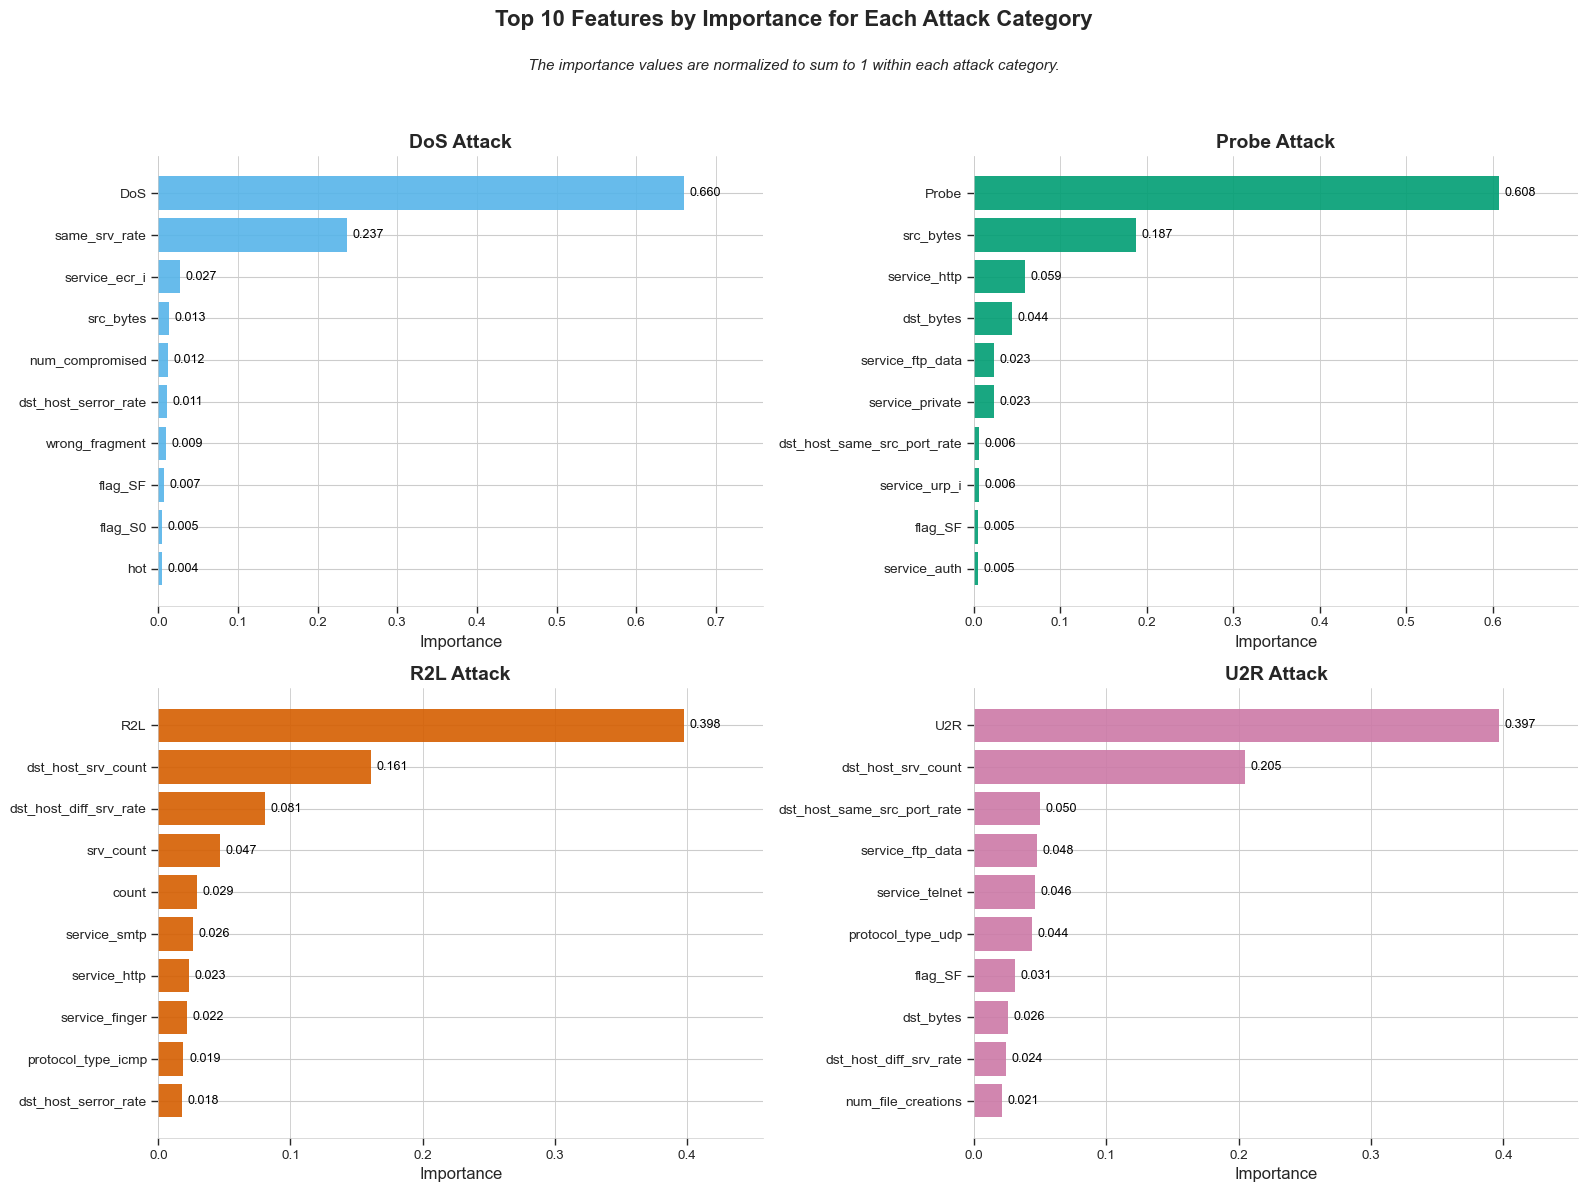

Feature importance visualization saved as 'figure1_feature_importance_replication.png' and displayed.
Generating feature reduction plot...


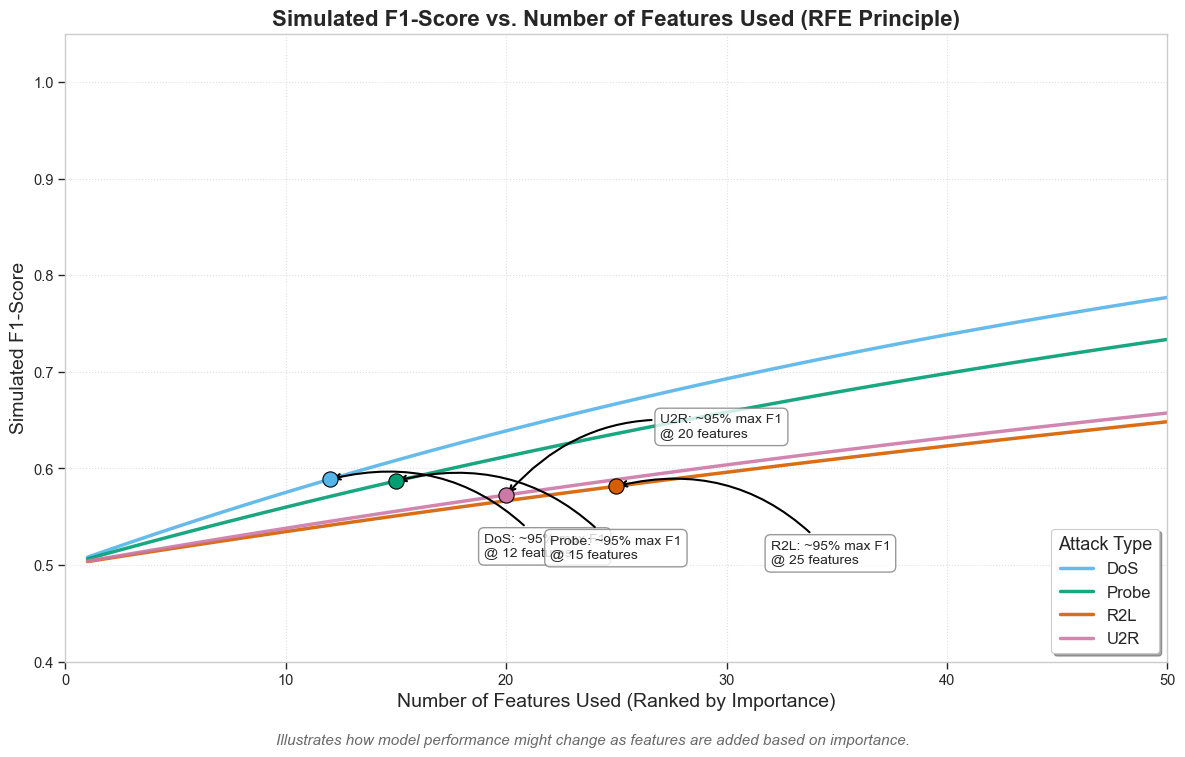

Feature reduction analysis visualization saved as 'figure2_feature_reduction_simulated.png' and displayed.

--- Visualizations completed successfully. ---


In [53]:
# ARTIFACTS_FILENAME = 'deployment_artifacts_kmeans.pkl' 


def create_feature_importance_visualization(output_file='figure1_feature_importance_replication.png'):
    """
    Generates and saves a plot showing the top 10 feature importances
    for each attack class.
    """
    print("Generating feature importance plot...")

    # Set up the figure styles
    plt.style.use('seaborn-v0_8-whitegrid') # White grid background
    sns.set_context("paper", font_scale=1.1) 
    plt.rcParams['font.family'] = 'sans-serif' 

    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    plt.subplots_adjust(hspace=0.35, wspace=0.3) # Adjusted spacing

    # Define colors from the image
    colors = {
        'DoS': '#56B4E9',    # Sky Blue
        'Probe': '#009E73',  # Bluish Green
        'R2L': '#D55E00',    # Vermillion/Reddish Orange
        'U2R': '#CC79A7'     # Reddish Purple
    }

    attack_data = {
        'DoS': {
            'DoS': 0.660, 
            'same_srv_rate': 0.237,
            'service_ecr_i': 0.027,
            'src_bytes': 0.013,
            'num_compromised': 0.012,
            'dst_host_serror_rate': 0.011,
            'wrong_fragment': 0.009,
            'flag_SF': 0.007,
            'flag_S0': 0.005,
            'hot': 0.004
        },
        'Probe': {
            'Probe': 0.608, 
            'src_bytes': 0.187,
            'service_http': 0.059,
            'dst_bytes': 0.044,
            'service_private': 0.023, 
            'service_ftp_data': 0.023,
            'service_urp_i': 0.006, 
            'dst_host_same_src_port_rate': 0.006,
            'service_auth': 0.005, 
            'flag_SF': 0.005
        },
        'R2L': {
            'R2L': 0.398, 
            'dst_host_srv_count': 0.161,
            'dst_host_diff_srv_rate': 0.081, 
            'srv_count': 0.047,
            'count': 0.029,
            'service_smtp': 0.026,
            'service_http': 0.023,
            'service_finger': 0.022,
            'protocol_type_icmp': 0.019,
            'dst_host_serror_rate': 0.018
        },
        'U2R': {
            'U2R': 0.397, 
            'dst_host_srv_count': 0.205,
            'dst_host_same_src_port_rate': 0.050,
            'service_ftp_data': 0.048,
            'service_telnet': 0.046,
            'protocol_type_udp': 0.044,
            'flag_SF': 0.031,
            'dst_bytes': 0.026,
            'dst_host_diff_srv_rate': 0.024,
            'num_file_creations': 0.021
        }
    }

    attack_types_list = ['DoS', 'Probe', 'R2L', 'U2R']

    # Plot each attack type in its own subplot
    for i, attack_type in enumerate(attack_types_list):
        # Determine subplot position
        row = i // 2
        col = i % 2
        ax = axes[row, col]

        features_dict = attack_data[attack_type]
        df_plot = pd.DataFrame({
            'Feature': list(features_dict.keys()),
            'Importance': list(features_dict.values())
        })

        # Sort by importance for plotting (highest importance at the top)
        df_plot = df_plot.sort_values('Importance', ascending=True)

        # Plotting
        bars = ax.barh(df_plot['Feature'], df_plot['Importance'], color=colors[attack_type], alpha=0.9) 

        # Add value labels next to bars
        for bar in bars:
            width = bar.get_width()
            # Position label slightly to the right of the bar end
            label_x_pos = width + (ax.get_xlim()[1] * 0.01) 
            ax.text(label_x_pos, bar.get_y() + bar.get_height()/2., f'{width:.3f}', 
                    va='center', ha='left', color='black', fontsize=9) 

        # Set title and labels
        ax.set_title(f'{attack_type} Attack', fontsize=14, fontweight='bold') 
        ax.set_xlabel('Importance', fontsize=12)

        # Adjust x-axis limits based on max value in the specific subplot, adding padding
        max_val = df_plot['Importance'].max()
        ax.set_xlim(0, max_val * 1.15) # Add ~15% padding for labels

        # Remove the y-axis label
        ax.set_ylabel('')
        ax.tick_params(axis='y', labelsize=10) 

        # Grid only on the x-axis
        ax.grid(axis='x', linestyle='-', linewidth=0.5, alpha=0.5, color='grey') 

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(0.5)
        ax.spines['bottom'].set_linewidth(0.5)

        # Set axis below grid
        ax.set_axisbelow(True)

    fig.suptitle('Top 10 Features by Importance for Each Attack Category', fontsize=16, fontweight='bold', y=0.99)

    plt.figtext(0.5, 0.94, 'The importance values are normalized to sum to 1 within each attack category.',
                ha='center', fontsize=11, style='italic') 

    # Adjust layout and save
    plt.tight_layout(rect=[0, 0, 1, 0.93]) # Adjust rect to prevent title/subtitle overlap
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show() 
    plt.close(fig) 

    print(f"Feature importance visualization saved as '{output_file}' and displayed.")


# Feature Reduction Visualization
def create_feature_reduction_visualization(output_file='figure2_feature_reduction_simulated.png'):
    """
    Generates and saves a plot illustrating the concept of
    feature reduction/selection impact on F1-score.
    """
    print("Generating feature reduction plot...")
    # Set up the figure styles
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_context("paper", font_scale=1.2)
    plt.rcParams['font.family'] = 'sans-serif'

    # Create figure
    fig = plt.figure(figsize=(12, 8))

    # Define colors
    colors = {
        'DoS': '#56B4E9',    # Sky Blue
        'Probe': '#009E73',  # Bluish Green
        'R2L': '#D55E00',    # Vermillion/Reddish Orange
        'U2R': '#CC79A7'     # Reddish Purple
    }

    # Create simulated feature reduction data
    max_features = 127 
    x = np.arange(1, max_features + 1)

    # Model the F1-score as a function that quickly rises and then plateaus
    def f1_curve(x, plateau_point, max_value=0.99, start_value=0.5, steepness=0.2):
        return max_value - (max_value - start_value) * np.exp(-steepness * x / plateau_point)

    # Points where ~95% of max F1 is supposedly reached (simulated)
    plateau_points = { 'DoS': 12, 'Probe': 15, 'R2L': 25, 'U2R': 20 } # Example points
    markers = plateau_points

    # Plot F1-score curves
    for attack, plateau in plateau_points.items():
        max_f1 = {'DoS': 0.99, 'Probe': 0.98, 'R2L': 0.95, 'U2R': 0.90}.get(attack, 0.95)
        f1_scores = f1_curve(x, plateau, max_value=max_f1)
        plt.plot(x, f1_scores, label=attack, linewidth=2.5, color=colors[attack], alpha=0.9)
        marker_x = markers[attack]
        marker_y = f1_curve(marker_x, plateau, max_value=max_f1)
        plt.scatter(marker_x, marker_y, s=120, color=colors[attack], edgecolor='black', zorder=5, marker='o')
        plt.annotate(f'{attack}: ~95% max F1\n@ {marker_x} features',
                   xy=(marker_x, marker_y),
                   xytext=(marker_x + 7, marker_y - 0.08 if attack not in ['U2R'] else marker_y + 0.06),
                   fontsize=10,
                   arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.3", color='black', lw=1.5),
                   bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="gray", lw=1, alpha=0.8))

    # Titles and labels
    plt.title('Simulated F1-Score vs. Number of Features Used (RFE Principle)', fontsize=16, fontweight='bold')
    plt.xlabel('Number of Features Used (Ranked by Importance)', fontsize=14)
    plt.ylabel('Simulated F1-Score', fontsize=14)
    plt.xlim(0, 50)
    plt.ylim(0.4, 1.05)
    plt.legend(title='Attack Type', fontsize=12, title_fontsize=13, loc='lower right', frameon=True, shadow=True)
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.figtext(0.5, 0.01,
                'Illustrates how model performance might change as features are added based on importance.',
                ha='center', fontsize=11, style='italic', color='dimgray')

    # Save figure
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)

    print(f"Feature reduction analysis visualization saved as '{output_file}' and displayed.")


# Run the visualization functions
print("--- Generating Visualizations ---")
create_feature_importance_visualization() 
create_feature_reduction_visualization()  
print("\n--- Visualizations completed successfully. ---")